<a href="https://colab.research.google.com/github/tzs930/deeprl_practice_colab/blob/master/day3/day3_GAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAIL (Generative Adversarial Imitation Learning) 실습

이번 실습자료는 GAIL 저자 (Jonathan Ho)의  [구현코드](/https://github.com/openai/imitation.git)를 바탕으로 제작되었습니다. 직접적인 구현 자체 (`TrainsitionClassifier`, `ImitationOptimizer`) 위주로 실습자료를 만들었고, 구현에 필요한 유틸리티 메서드들은 저자코드 저장소에서 그대로 받아와서 사용하도록 제작했습니다.

## 환경설정

In [1]:
!apt-get install -y xvfb python-opengl swig ffmpeg zlib1g-dev python3-tk
!pip install theano==0.8.2 gym==0.1.0 mujoco_py==0.4.0 
!pip install JSAnimation PyOpenGL piglet pyglet xlib pyvirtualdisplay box2d-py mako==1.0.7 
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
python-opengl is already the newest version (3.1.0+dfsg-1).
swig is already the newest version (3.0.12-1).
python3-tk is already the newest version (3.6.7-1~18.04).
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
!git init .
!git remote add origin https://github.com/tzs930/imitation.git
!git pull origin master

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/tzs930/imitation
 * branch            master     -> FETCH_HEAD
Already up to date.


## Hyperparameter 설정


### 데이터 입력 관련

- `data` : 전문가 행동데이터(Expert trajectory)들이 저장된 `.h5` 파일의 경로를 지정합니다.
- `limit_trajs` : 최대 몇개의 Expert episode를 가져올지 지정합니다. 작아질수록 학습에 들어가는 데이터의 양이 적어집니다.
- `data_subsamp_freq` : 한 Episode 내에서 Subsampling을 얼마나 할지 지정합니다. 1일 경우 Subsampling을 하지 않고 모든 데이터를 사용합니다.

### Gym 환경 관련
- `env_name` : 어떤 Gym Environment에서 실험할 것인지 지정합니다. 반드시 `gym`에 등록(register)된 환경이어야 합니다. 
> e.g. `CartPole-v0`, `Acrobot-v0`, `MountainCar-v0`, ...
- `max_traj_len` :  Environment의 최대 에피소드 길이 값을 지정합니다.

In [0]:
# Expert dataset
data='expert_trajs/trajs_cartpole.h5'
limit_trajs=25
data_subsamp_freq=1

# MDP options
env_name='CartPole-v0'
max_traj_len=1000

### 학습 진행 관련 
- `min_total_sa` : 1번의 Policy Optimization에서 최대 몇개의 (s, a) 쌍을 샘플할 것인지 지정합니다.
- `max_iter` :  최대 몇 번의 Iteration을 학습할 것인지 지정합니다. 

한 번의 Iteration은 outer-loop에서 *Reward 학습*, inner-loop에서 *Policy 학습* 의 2단계로 이루어지며,  Inner loop에서 샘플된 (s,a)을 이용하여 TRPO를 학습하므로 사실상  `min_total_sa * max_iter` 만큼의 학습이 진행되게 됩니다.


### 저장 및 출력 관련 

- `print_freq` : 학습 도중 결과를 얼마나 자주 출력할지 지정합니다.
- `save_freq` :  학습 도중 결과 및 모델을 얼마나 자주 저장할지 지정합니다.
- `plot_freq` : 학습 도중 그래프를 얼마나 자주 출력할지 지정합니다.
- `logfilename` : 저장될 로그 및 학습결과의 경로를 지정합니다.

In [0]:
# Learning hyperparameters
min_total_sa=50000
max_iter=200

# Saving hyperparameters
print_freq=1
save_freq=10
plot_freq=10
logfilename='./' + env_name + '.h5'

### Reward 학습 관련 
- `reward_steps` : 한 번의 Reward optimization마다 몇 step의 update를 할 것인지 지정합니다.
- `reward_lr` :  Reward의 Learning Rate를 지정합니다.
- `reward_ent_reg_weight` :  Reward Loss에 적용되는 Entropy Regularization 정도를 지정합니다.
- `favor_zero_expert_reward` : Discriminator가 Expert trajectory를 1 또는 0으로 판단할 지 지정합니다. 가능한 한 빨리 도달해야하는 태스크들(ex. `MountainCar-v0`) 의 경우 이 옵션(`favor_zero_expert_reward=1`)이 필요합니다.


### TRPO (Trust-Region Policy Optimization) 관련 

GAIL은 inner-loop에서 RL Optimization을 이용하여 Policy를 학습시키는데, TRPO [(Schulman. J. et al., 2015)](https://arxiv.org/abs/1502.05477)를 사용하여 학습합니다. 이번 실습에서는 TRPO가 중점이 아니므로 이 부분은 생략합니다.



In [0]:
# Reward hyperparameters
reward_steps=1
reward_lr=.01
reward_ent_reg_weight=.001
favor_zero_expert_reward=0

# TRPO hyperparameters
discount=.995
lam=.97
policy_max_kl=.01
policy_cg_damping=.1
vf_max_kl=.01
vf_cg_damping=.1
policy_ent_reg=0.

## Generative Adversarial Learning을 통해 Reward를 학습 : `TrainsitionClassifier`

GAIL에서는 Discriminator를 local reward 혹은 cost function으로 삼아서 학습을 하게 됩니다. 따라서, $w$는 Discriminator의 weight, $D_w : \mathcal S \times \mathcal A  \to (0,1)$ 는 Discriminator network라고 하면  reward function는 다음과 같습니다. 

\begin{equation}\
r(s,a) = \log D_w (s,a)
\end{equation}




In [0]:
from policyopt import nn, rl, util, RaggedArray, ContinuousSpace, FiniteSpace, optim, thutil
import numpy as np
from contextlib import contextmanager
import theano; from theano import tensor

class TransitionClassifier(nn.Model):
    '''Reward/adversary for generative-adversarial training'''

    def __init__(self, obsfeat_space, action_space, hidden_spec, adam_lr, adam_steps, ent_reg_weight,
                 enable_inputnorm, include_time, time_scale, favor_zero_expert_reward, varscope_name):
        self.obsfeat_space, self.action_space = obsfeat_space, action_space
        self.hidden_spec = hidden_spec        
        self.adam_steps = adam_steps
        self.ent_reg_weight = ent_reg_weight; assert ent_reg_weight >= 0
        self.include_time = include_time
        self.time_scale = time_scale
        self.favor_zero_expert_reward = favor_zero_expert_reward

        with nn.variable_scope(varscope_name) as self.__varscope:
            # Map (s,a) pairs to classifier scores (log probabilities of classes)
            obsfeat_B_Df = tensor.matrix(name='obsfeat_B_Df')
            a_B_Da = tensor.matrix(name='a_B_Da', dtype=theano.config.floatX if self.action_space.storage_type == float else 'int64')
            t_B = tensor.vector(name='t_B')

            scaled_t_B = self.time_scale * t_B

            if isinstance(self.action_space, ContinuousSpace):
                # For a continuous action space, map observation-action pairs to a real number (reward)
                trans_B_Doa = tensor.concatenate([obsfeat_B_Df, a_B_Da], axis=1)
                trans_dim = self.obsfeat_space.dim + self.action_space.dim
                # Normalize
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim + self.action_space.dim)
                normedtrans_B_Doa = self.inputnorm.standardize_expr(trans_B_Doa)
                if self.include_time:
                    net_input = tensor.concatenate([normedtrans_B_Doa, scaled_t_B[:,None]], axis=1)
                    net_input_dim = trans_dim + 1
                else:
                    net_input = normedtrans_B_Doa
                    net_input_dim = trans_dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(net.output, net.output_shape, (1,), initializer=np.zeros((net.output_shape[0], 1)))
                scores_B = out_layer.output[:,0]

            else:
                # For a finite action space, map observation observations to a vector of rewards

                # Normalize observations
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim)
                normedobs_B_Df = self.inputnorm.standardize_expr(obsfeat_B_Df)
                if self.include_time:
                    net_input = tensor.concatenate([normedobs_B_Df, scaled_t_B[:,None]], axis=1)
                    net_input_dim = self.obsfeat_space.dim + 1
                else:
                    net_input = normedobs_B_Df
                    net_input_dim = self.obsfeat_space.dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(
                        net.output, net.output_shape, (self.action_space.size,),
                        initializer=np.zeros((net.output_shape[0], self.action_space.size)))
                scores_B = out_layer.output[tensor.arange(normedobs_B_Df.shape[0]), a_B_Da[:,0]]


        if self.include_time:
            self._compute_scores = thutil.function([obsfeat_B_Df, a_B_Da, t_B], scores_B) # scores define the conditional distribution p(label | (state,action))
            
        else:
            compute_scores_without_time = thutil.function([obsfeat_B_Df, a_B_Da], scores_B)
            self._compute_scores = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_scores_without_time(_obsfeat_B_Df, _a_B_Da)

        if self.favor_zero_expert_reward:
            # 0 for expert-like states, goes to -inf for non-expert-like states
            # compatible with envs with traj cutoffs for good (expert-like) behavior
            # e.g. mountain car, which gets cut off when the car reaches the destination
            rewards_B = thutil.logsigmoid(scores_B)
            
        else:
            # 0 for non-expert-like states, goes to +inf for expert-like states
            # compatible with envs with traj cutoffs for bad (non-expert-like) behavior
            # e.g. walking simulations that get cut off when the robot falls over
            rewards_B = -tensor.log(1.-tensor.nnet.sigmoid(scores_B))
            
        if self.include_time:
            self._compute_reward = thutil.function([obsfeat_B_Df, a_B_Da, t_B], rewards_B)
            
        else:
            compute_reward_without_time = thutil.function([obsfeat_B_Df, a_B_Da], rewards_B)
            self._compute_reward = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_reward_without_time(_obsfeat_B_Df, _a_B_Da)

        param_vars = self.get_trainable_variables()

        # Logistic regression loss, regularized by negative entropy
        labels_B = tensor.vector(name='labels_B')
        weights_B = tensor.vector(name='weights_B')
        losses_B = thutil.sigmoid_cross_entropy_with_logits(scores_B, labels_B)
        ent_B = thutil.logit_bernoulli_entropy(scores_B)
        loss = ((losses_B - self.ent_reg_weight*ent_B)*weights_B).sum(axis=0)
        lossgrad_P = thutil.flatgrad(loss, param_vars)

        if self.include_time:
            self._adamstep = thutil.function(
                [obsfeat_B_Df, a_B_Da, t_B, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
        else:
            adamstep_without_time = thutil.function(
                [obsfeat_B_Df, a_B_Da, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
            self._adamstep = lambda _obsfeat_B_Df, _a_B_Da, _t_B, _labels_B, _weights_B: adamstep_without_time(_obsfeat_B_Df, _a_B_Da, _labels_B, _weights_B)

    @property
    def varscope(self): return self.__varscope

    def compute_reward(self, obsfeat_B_Df, a_B_Da, t_B):
        return self._compute_reward(obsfeat_B_Df, a_B_Da, t_B)

    def fit(self, obsfeat_B_Df, a_B_Da, t_B, exobs_Bex_Do, exa_Bex_Da, ext_Bex):
        # Transitions from the current policy go first, then transitions from the expert
        obsfeat_Ball_Df = np.concatenate([obsfeat_B_Df, exobs_Bex_Do])
        a_Ball_Da = np.concatenate([a_B_Da, exa_Bex_Da])
        t_Ball = np.concatenate([t_B, ext_Bex])

        # Update normalization
        self.update_inputnorm(obsfeat_Ball_Df, a_Ball_Da)

        B = obsfeat_B_Df.shape[0] # number of examples from the current policy
        Ball = obsfeat_Ball_Df.shape[0] # Ball - b = num examples from expert

        # Label expert as 1, current policy as 0
        labels_Ball = np.zeros(Ball)
        labels_Ball[B:] = 1.

        # Evenly weight the loss terms for the expert and the current policy
        weights_Ball = np.zeros(Ball)
        weights_Ball[:B] = 1./B
        weights_Ball[B:] = 1./(Ball - B); assert len(weights_Ball[B:]) == Ball-B

        # Optimize
        for _ in range(self.adam_steps):
            loss, kl, num_bt_steps = self._adamstep(obsfeat_Ball_Df, a_Ball_Da, t_Ball, labels_Ball, weights_Ball), None, 0

        # Evaluate
        scores_Ball = self._compute_scores(obsfeat_Ball_Df, a_Ball_Da, t_Ball); assert scores_Ball.shape == (Ball,)
        accuracy = .5 * (weights_Ball * ((scores_Ball < 0) == (labels_Ball == 0))).sum()
        accuracy_for_currpolicy = (scores_Ball[:B] <= 0).mean()
        accuracy_for_expert = (scores_Ball[B:] > 0).mean()
        assert np.allclose(accuracy, .5*(accuracy_for_currpolicy + accuracy_for_expert))

        return [
            ('rloss', loss, float), # reward function fitting loss
            ('racc', accuracy, float), # reward function accuracy
            ('raccpi', accuracy_for_currpolicy, float), # reward function accuracy
            ('raccex', accuracy_for_expert, float), # reward function accuracy
            ('rkl', kl, float),
            ('rbt', num_bt_steps, int),
            # ('rpnorm', util.maxnorm(self.get_params()), float),
            # ('snorm', util.maxnorm(scores_Ball), float),
        ]

    def update_inputnorm(self, obs_B_Do, a_B_Da):
        if isinstance(self.action_space, ContinuousSpace):
            self.inputnorm.update(np.concatenate([obs_B_Do, a_B_Da], axis=1))
        else:
            self.inputnorm.update(obs_B_Do)

    def plot(self, ax, idx1, idx2, range1, range2, n=100):
        assert len(range1) == len(range2) == 2 and idx1 != idx2
        x, y = np.mgrid[range1[0]:range1[1]:(n+0j), range2[0]:range2[1]:(n+0j)]

        if isinstance(self.action_space, ContinuousSpace):
            points_B_Doa = np.zeros((n*n, self.obsfeat_space.storage_size + self.action_space.storage_size))
            points_B_Doa[:,idx1] = x.ravel()
            points_B_Doa[:,idx2] = y.ravel()
            obsfeat_B_Df, a_B_Da = points_B_Doa[:,:self.obsfeat_space.storage_size], points_B_Doa[:,self.obsfeat_space.storage_size:]
            assert a_B_Da.shape[1] == self.action_space.storage_size
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)
        else:
            obsfeat_B_Df = np.zeros((n*n, self.obsfeat_space.storage_size))
            obsfeat_B_Df[:,idx1] = x.ravel()
            obsfeat_B_Df[:,idx2] = y.ravel()
            a_B_Da = np.zeros((obsfeat_B_Df.shape[0], 1), dtype=np.int32) # XXX make customizable
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)

        ax.pcolormesh(x, y, z, cmap='viridis')
        # ax.contour(x, y, z, levels=np.log(np.linspace(2., 3., 10)))
        ax.contourf(x, y, z, levels=[np.log(2.), np.log(2.)+.5], alpha=.5) # high-reward region is highlighted
        

## 학습한 Reward로 Policy Optimization :  `ImitationOptimizer`

여기서는 Discriminator의 Parameter인 $w$를 다음과 같이 학습하는 부분을 포함하고 있습니다.

\begin{equation}\
w_{i+1} \leftarrow w_i - \eta \space \mathbb{E}_{\tau_i} [ \nabla_w log(D_w (s,a))] + \mathbb E_{\tau_E} [\nabla_w \log(1-D_w(s,a))] \tag{17}
\end{equation}

In [0]:
import pickle
class ImitationOptimizer(object):
    def __init__(self, mdp, discount, lam, policy, sim_cfg, step_func, reward_func, value_func,
                 policy_obsfeat_fn, reward_obsfeat_fn, policy_ent_reg, ex_obs, ex_a, ex_t):
        self.mdp, self.discount, self.lam, self.policy = mdp, discount, lam, policy
        self.sim_cfg = sim_cfg
        self.step_func = step_func
        self.reward_func = reward_func
        self.value_func = value_func
        # assert value_func is not None, 'not tested'
        self.policy_obsfeat_fn = policy_obsfeat_fn
        self.reward_obsfeat_fn = reward_obsfeat_fn
        self.policy_ent_reg = policy_ent_reg
        util.header('Policy entropy regularization: {}'.format(self.policy_ent_reg))

        assert ex_obs.ndim == ex_a.ndim == 2 and ex_t.ndim == 1 and ex_obs.shape[0] == ex_a.shape[0] == ex_t.shape[0]
        self.ex_pobsfeat, self.ex_robsfeat, self.ex_a, self.ex_t = policy_obsfeat_fn(ex_obs), reward_obsfeat_fn(ex_obs), ex_a, ex_t

        self.total_num_trajs = 0
        self.total_num_sa = 0
        self.total_time = 0.
        self.curr_iter = 0
        self.last_sampbatch = None # for outside access for debugging

    def step(self):
        with util.Timer() as t_all:

            # Sample trajectories using current policy
            # print 'Sampling'
            with util.Timer() as t_sample:
                sampbatch = self.mdp.sim_mp(
                    policy_fn=lambda obsfeat_B_Df: self.policy.sample_actions(obsfeat_B_Df),
                    obsfeat_fn=self.policy_obsfeat_fn,
                    cfg=self.sim_cfg)
                samp_pobsfeat = sampbatch.obsfeat
                self.last_sampbatch = sampbatch

            # Compute baseline / advantages
            # print 'Computing advantages'
            with util.Timer() as t_adv:
                # Compute observation features for reward input
                samp_robsfeat_stacked = self.reward_obsfeat_fn(sampbatch.obs.stacked)
                # Reward is computed wrt current reward function
                # TODO: normalize rewards
                rcurr_stacked = self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked)
                assert rcurr_stacked.shape == (samp_robsfeat_stacked.shape[0],)

                # If we're regularizing the policy, add negative log probabilities to the rewards
                # Intuitively, the policy gets a bonus for being less certain of its actions
                orig_rcurr_stacked = rcurr_stacked.copy()
                if self.policy_ent_reg is not None and self.policy_ent_reg != 0:
                    assert self.policy_ent_reg > 0
                    # XXX probably faster to compute this from sampbatch.adist instead
                    actionlogprobs_B = self.policy.compute_action_logprobs(samp_pobsfeat.stacked, sampbatch.a.stacked)
                    policyentbonus_B = -self.policy_ent_reg * actionlogprobs_B
                    rcurr_stacked += policyentbonus_B
                else:
                    policyentbonus_B = np.zeros_like(rcurr_stacked)

                rcurr = RaggedArray(rcurr_stacked, lengths=sampbatch.r.lengths)

                # Compute advantages using these rewards
                advantages, qvals, vfunc_r2, simplev_r2 = rl.compute_advantage(
                    rcurr, samp_pobsfeat, sampbatch.time, self.value_func, self.discount, self.lam)

            # Take a step
            # print 'Fitting policy'
            with util.Timer() as t_step:
                params0_P = self.policy.get_params()
                step_print = self.step_func(
                    self.policy, params0_P,
                    samp_pobsfeat.stacked, sampbatch.a.stacked, sampbatch.adist.stacked,
                    advantages.stacked)
                self.policy.update_obsnorm(samp_pobsfeat.stacked)

            # Fit reward function
            # print 'Fitting reward'
            with util.Timer() as t_r_fit:
                if True:#self.curr_iter % 20 == 0:
                    # Subsample expert transitions to the same sample count for the policy
                    inds = np.random.choice(self.ex_robsfeat.shape[0], size=samp_pobsfeat.stacked.shape[0])
                    exbatch_robsfeat = self.ex_robsfeat[inds,:]
                    exbatch_pobsfeat = self.ex_pobsfeat[inds,:] # only used for logging
                    exbatch_a = self.ex_a[inds,:]
                    exbatch_t = self.ex_t[inds]
                    rfit_print = self.reward_func.fit(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked, exbatch_robsfeat, exbatch_a, exbatch_t)
                else:
                    rfit_print = []

            # Fit value function for next iteration
            # print 'Fitting value function'
            with util.Timer() as t_vf_fit:
                if self.value_func is not None:
                    # Recompute q vals # XXX: this is only necessary if fitting reward after policy
                    # qnew = qvals

                    # TODO: this should be a byproduct of reward fitting
                    rnew = RaggedArray(
                        self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked),
                        lengths=sampbatch.r.lengths)
                    qnew, _ = rl.compute_qvals(rnew, self.discount)
                    vfit_print = self.value_func.fit(samp_pobsfeat.stacked, sampbatch.time.stacked, qnew.stacked)
                else:
                    vfit_print = []

        # Log
        self.total_num_trajs += len(sampbatch)
        self.total_num_sa += sum(len(traj) for traj in sampbatch)
        self.total_time += t_all.dt
        fields = [
            ('iter', self.curr_iter, int),
            ('trueret', sampbatch.r.padded(fill=0.).sum(axis=1).mean(), float), # average return for this batch of trajectories
            ('iret', rcurr.padded(fill=0.).sum(axis=1).mean(), float), # average return on imitation reward
            ('avglen', int(np.mean([len(traj) for traj in sampbatch])), int), # average traj length
            ('ntrajs', self.total_num_trajs, int), # total number of trajs sampled over the course of training
            ('nsa', self.total_num_sa, int), # total number of state-action pairs sampled over the course of training
            ('ent', self.policy._compute_actiondist_entropy(sampbatch.adist.stacked).mean(), float), # entropy of action distributions
            ('vf_r2', vfunc_r2, float),
            ('tdvf_r2', simplev_r2, float),
            ('dx', util.maxnorm(params0_P - self.policy.get_params()), float), # max parameter difference from last iteration
        ] + step_print + vfit_print + rfit_print + [
            ('avgr', rcurr_stacked.mean(), float), # average regularized reward encountered
            ('avgunregr', orig_rcurr_stacked.mean(), float), # average unregularized reward
            ('avgpreg', policyentbonus_B.mean(), float), # average policy regularization
            # ('bcloss', -self.policy.compute_action_logprobs(exbatch_pobsfeat, exbatch_a).mean(), float), # negative log likelihood of expert actions
            # ('bcloss', np.square(self.policy.compute_actiondist_mean(exbatch_pobsfeat) - exbatch_a).sum(axis=1).mean(axis=0), float),
            ('tsamp', t_sample.dt, float), # time for sampling
            ('tadv', t_adv.dt + t_vf_fit.dt, float), # time for advantage computation
            ('tstep', t_step.dt, float), # time for step computation
            ('ttotal', self.total_time, float), # total time
        ]
        self.curr_iter += 1
        return fields

# 메인함수

In [0]:
import argparse, h5py, json
import numpy as np
from environments import rlgymenv
import policyopt
from policyopt import imitation, nn, rl, util

In [8]:
# main
mdp = rlgymenv.RLGymMDP(env_name)
util.header('MDP observation space, action space sizes: %d, %d\n' % (mdp.obs_space.dim, mdp.action_space.storage_size))

# Policy architecture
OBSNORM_MODES = ('none', 'expertdata', 'online')
TINY_ARCHITECTURE = '[{"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}]'
SIMPLE_ARCHITECTURE = '[{"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}]'

obsnorm_mode='expertdata'
sim_batch_size=1
policy_hidden_spec=SIMPLE_ARCHITECTURE

# Initialize the policy
enable_obsnorm = obsnorm_mode != 'none'
if isinstance(mdp.action_space, policyopt.ContinuousSpace):
    policy_cfg = rl.GaussianPolicyConfig(
        hidden_spec=policy_hidden_spec,
        min_stdev=0.,
        init_logstdev=0.,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GaussianPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GaussianPolicy')
else:
    policy_cfg = rl.GibbsPolicyConfig(
        hidden_spec=policy_hidden_spec,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GibbsPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GibbsPolicy')

util.header('Policy architecture')
for v in policy.get_trainable_variables():
    util.header('- %s (%d parameters)' % (v.name, v.get_value().size))
util.header('Total: %d parameters' % (policy.get_num_params(),))

# Load expert data
def load_dataset(filename, limit_trajs, data_subsamp_freq):
    # Load expert data
    with h5py.File(filename, 'r') as f:
        # Read data as written by vis_mj.py
        full_dset_size = f['obs_B_T_Do'].shape[0] # full dataset size
        dset_size = min(full_dset_size, limit_trajs) if limit_trajs is not None else full_dset_size

        exobs_B_T_Do = f['obs_B_T_Do'][:dset_size,...][...]
        exa_B_T_Da = f['a_B_T_Da'][:dset_size,...][...]
        exr_B_T = f['r_B_T'][:dset_size,...][...]
        exlen_B = f['len_B'][:dset_size,...][...]

    print 'Expert dataset size: {} transitions ({} trajectories)'.format(exlen_B.sum(), len(exlen_B))
    print 'Expert average return:', exr_B_T.sum(axis=1).mean()
 
    # Stack everything together
    start_times_B = np.random.RandomState(0).randint(0, data_subsamp_freq, size=exlen_B.shape[0])
    print 'start times'
    print start_times_B
    exobs_Bstacked_Do = np.concatenate(
        [exobs_B_T_Do[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    exa_Bstacked_Da = np.concatenate(
        [exa_B_T_Da[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    ext_Bstacked = np.concatenate(
        [np.arange(start_times_B[i], l, step=data_subsamp_freq) for i, l in enumerate(exlen_B)]).astype(float)

    assert exobs_Bstacked_Do.shape[0] == exa_Bstacked_Da.shape[0] == ext_Bstacked.shape[0]# == np.ceil(exlen_B.astype(float)/data_subsamp_freq).astype(int).sum() > 0

    print 'Subsampled data every {} timestep(s)'.format(data_subsamp_freq)
    print 'Final dataset size: {} transitions (average {} per traj)'.format(exobs_Bstacked_Do.shape[0], float(exobs_Bstacked_Do.shape[0])/dset_size)

    return exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked
  
exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked = load_dataset(
    data, limit_trajs, data_subsamp_freq)

assert exobs_Bstacked_Do.shape[1] == mdp.obs_space.storage_size
assert exa_Bstacked_Da.shape[1] == mdp.action_space.storage_size
assert ext_Bstacked.ndim == 1

# Start optimization
max_traj_len = max_traj_len if max_traj_len is not None else mdp.env_spec.timestep_limit
print 'Max traj len:', max_traj_len

reward = TransitionClassifier(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    action_space=mdp.action_space,    
    adam_lr=reward_lr,
    adam_steps=reward_steps,
    ent_reg_weight=reward_ent_reg_weight,
    enable_inputnorm=True,
    include_time=False,
    time_scale=1./mdp.env_spec.timestep_limit,
    favor_zero_expert_reward=bool(favor_zero_expert_reward),
    varscope_name='TransitionClassifier')

vf = rl.ValueFunc(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    enable_obsnorm=obsnorm_mode != 'none',
    enable_vnorm=True,
    max_kl=vf_max_kl,
    damping=vf_cg_damping,
    time_scale=1./mdp.env_spec.timestep_limit,
    varscope_name='ValueFunc')

opt = ImitationOptimizer(
    mdp=mdp,
    discount=discount,
    lam=lam,
    policy=policy,
    sim_cfg=policyopt.SimConfig(
        min_num_trajs=-1, min_total_sa=min_total_sa,
        batch_size=sim_batch_size, max_traj_len=max_traj_len),
    step_func=rl.TRPO(max_kl=policy_max_kl, damping=policy_cg_damping),
    reward_func=reward,
    value_func=vf,
    policy_obsfeat_fn=lambda obs: obs,
    reward_obsfeat_fn=lambda obs: obs,
    policy_ent_reg=policy_ent_reg,
    ex_obs=exobs_Bstacked_Do,
    ex_a=exa_Bstacked_Da,
    ex_t=ext_Bstacked)

# Set observation normalization
if obsnorm_mode == 'expertdata':
    policy.update_obsnorm(exobs_Bstacked_Do)
    if reward is not None: reward.update_inputnorm(opt.reward_obsfeat_fn(exobs_Bstacked_Do), exa_Bstacked_Da)
    if vf is not None: vf.update_obsnorm(opt.policy_obsfeat_fn(exobs_Bstacked_Do))

Gym version: 0.1.0
MDP observation space, action space sizes: 4, 1



/usr/local/lib/python2.7/dist-packages/gym/envs/registration.py:13: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Loading feedforward net specification
[
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  },
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  }
]
Affine(in=4, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=2)
Policy architecture
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/W (400 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/b (100 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/W (10000 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/b (100 parameters)
- /GibbsPolicy/out/AffineLayer/W (200 parameters)
- /GibbsPolicy/out/AffineLayer/b (2 parameters)
Total: 10802 parameters
Expert dataset size: 3400 transitions (17 trajectories)
Expert average return: 200.0
start times
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Subsampled data every 1 timestep(s)
Final dataset size: 3400 transitions (average 

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Policy entropy regularization: 0.0


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  iter   | trueret  |   iret   |  avglen  |  ntrajs  |   nsa    |   ent    |  vf_r2   | tdvf_r2  |    dx    |    dl    |    kl    |  gnorm   |    bt    |  vf_dl   |  vf_kl   | vf_gnorm |  vf_bt   |  rloss   |   racc   |  raccpi  |  raccex  |   rkl    |   rbt    |   avgr   | avgunregr | avgpreg  |  tsamp   |   tadv   |  tstep   |  ttotal 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

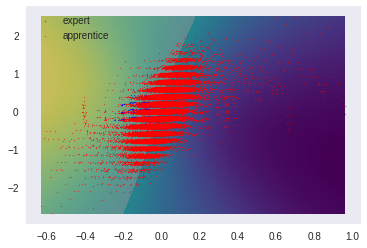

       1 |  26.2387 |  17.9692 |       26 |     4155 |   100020 |   0.6894 |   0.0083 |   0.0750 |   0.0310 |   0.0244 |   0.0094 |   0.0376 |        0 |   0.0410 |   0.0104 |   0.2172 |        0 |   1.3557 |   0.6929 |   0.5895 |   0.7962 |          |        0 |   0.6848 |   0.6848 |   0.0000 |   8.0943 |   5.1384 |   3.4999 |  38.6399
       2 |  36.8336 |  25.5044 |       36 |     5513 |   150040 |   0.6734 |   0.0459 |   0.0286 |   0.0255 |   0.0251 |   0.0096 |   0.0333 |        0 |   0.0939 |   0.0101 |   0.6902 |        0 |   1.3239 |   0.6841 |   0.5401 |   0.8280 |          |        0 |   0.6924 |   0.6924 |   0.0000 |   8.0774 |   5.2885 |   3.4928 |  57.6059
       3 |  59.8862 |  43.8515 |       59 |     6348 |   200045 |   0.6512 |   0.1021 |   0.0164 |   0.0245 |   0.0181 |   0.0094 |   0.0203 |        0 |   0.1426 |   0.0094 |   1.0805 |        0 |   1.3071 |   0.7058 |   0.5284 |   0.8831 |          |        0 |   0.7322 |   0.7322 |   0.0000 |   7.9498 |   5.5048 |   3

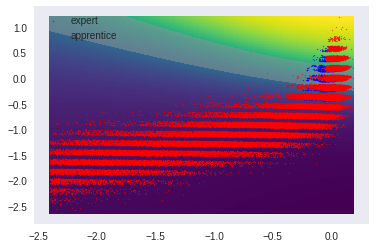

      11 | 136.0761 |  46.1239 |      136 |     9017 |   600426 |   0.5314 |  -0.0258 |   0.9446 |   0.0487 |   0.0025 |   0.0070 |   0.0038 |        0 |   0.1855 |   0.0097 |   1.9497 |        0 |   0.9400 |   0.7883 |   0.8949 |   0.6816 |          |        0 |   0.3390 |   0.3390 |   0.0000 |   7.8898 |   4.9924 |   3.6647 | 230.3143
      12 | 136.1685 |  39.9588 |      136 |     9385 |   650536 |   0.5240 |   0.0784 |   0.9349 |   0.0379 |   0.0012 |   0.0072 |   0.0024 |        0 |   0.1668 |   0.0097 |   1.7717 |        0 |   0.8460 |   0.8561 |   0.8980 |   0.8143 |          |        0 |   0.2935 |   0.2935 |   0.0000 |   7.9391 |   5.0097 |   3.6952 | 249.2197
      13 | 132.7586 |  36.3933 |      132 |     9762 |   700586 |   0.5289 |   0.1773 |   0.9201 |   0.0500 |   0.0014 |   0.0081 |   0.0029 |        0 |   0.1491 |   0.0096 |   1.5967 |        0 |   0.7416 |   0.9034 |   0.8884 |   0.9184 |          |        0 |   0.2741 |   0.2741 |   0.0000 |   8.1996 |   5.0319 |   3

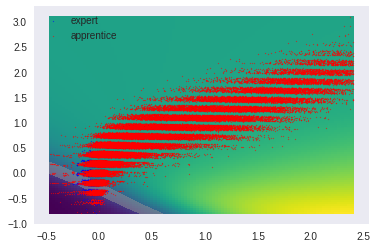

      21 | 143.6705 | 308.3483 |      143 |    12100 |  1101514 |   0.5227 |   0.1158 |   0.9002 |   0.0280 |   0.0021 |   0.0087 |   0.0039 |        0 |   0.0976 |   0.0098 |   0.3802 |        0 |   2.5405 |   0.3858 |   0.0061 |   0.7656 |          |        0 |   2.1462 |   2.1462 |   0.0000 |   7.9419 |   5.3822 |   3.8894 | 422.0606
      22 | 131.9472 | 197.6551 |      131 |    12479 |  1151522 |   0.5112 |   0.4409 |   0.9169 |   0.0258 |   0.0020 |   0.0087 |   0.0028 |        0 |   0.1153 |   0.0100 |   1.1846 |        0 |   2.1192 |   0.2767 |   0.0122 |   0.5413 |          |        0 |   1.4980 |   1.4980 |   0.0000 |   7.9221 |   5.0793 |   3.8160 | 441.2193
      23 | 130.7337 | 120.5077 |      130 |    12862 |  1201593 |   0.4911 |   0.7372 |   0.9448 |   0.0474 |   0.0014 |   0.0073 |   0.0014 |        0 |   0.1487 |   0.0096 |   1.6150 |        0 |   1.7514 |   0.5530 |   0.9760 |   0.1301 |          |        0 |   0.9218 |   0.9218 |   0.0000 |   7.9368 |   4.9746 |   3

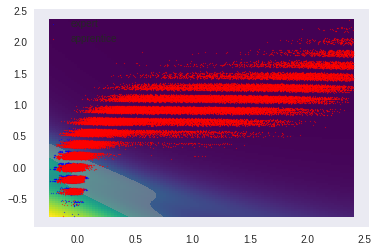

      31 | 185.9071 |  30.5685 |      185 |    15661 |  1602128 |   0.4318 |   0.1716 |   0.4900 |   0.0339 |   0.0133 |   0.0077 |   0.0271 |        0 |   0.0323 |   0.0089 |   0.4059 |        0 |   0.6062 |   0.9210 |   0.8970 |   0.9450 |          |        0 |   0.1644 |   0.1644 |   0.0000 |   7.8297 |   5.0698 |   3.6315 | 612.8683
      32 | 252.3467 |  94.6255 |      252 |    15860 |  1652345 |   0.4230 |   0.1735 |   0.1504 |   0.0328 |   0.0122 |   0.0085 |   0.0258 |        0 |   0.0808 |   0.0081 |   0.4620 |        0 |   0.6844 |   0.8735 |   0.7645 |   0.9825 |          |        0 |   0.3750 |   0.3750 |   0.0000 |   7.8901 |   5.3348 |   3.6072 | 631.9760
      33 | 319.3822 | 527.7540 |      319 |    16017 |  1702488 |   0.4135 |   0.1017 |   0.1017 |   0.0647 |   0.0075 |   0.0084 |   0.0181 |        0 |   0.4745 |   0.0101 |   4.1699 |        0 |   1.8600 |   0.6687 |   0.3425 |   0.9949 |          |        0 |   1.6524 |   1.6524 |   0.0000 |   7.8930 |   5.2823 |   3

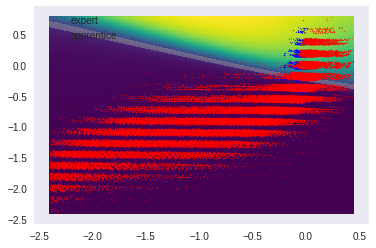

      41 | 246.9163 | 378.3452 |      246 |    18458 |  2103461 |   0.4007 |   0.0346 |   0.0515 |   0.0464 |   0.0076 |   0.0086 |   0.0188 |        0 |   0.2829 |   0.0083 |   1.8000 |        0 |   1.6491 |   0.7686 |   0.5665 |   0.9708 |          |        0 |   1.5323 |   1.5323 |   0.0000 |   7.8962 |   5.3346 |   3.7676 | 805.8245
      42 | 217.2468 | 682.0408 |      217 |    18689 |  2153645 |   0.4020 |   0.0493 |   0.1537 |   0.0557 |   0.0075 |   0.0090 |   0.0179 |        0 |   0.4284 |   0.0103 |   3.8102 |        0 |   3.2641 |   0.6117 |   0.2740 |   0.9494 |          |        0 |   3.1395 |   3.1395 |   0.0000 |   7.9088 |   5.3409 |   3.8202 | 825.1980
      43 | 176.2923 | 746.5565 |      176 |    18973 |  2203712 |   0.4051 |  -0.0186 |   0.4516 |   0.0355 |   0.0062 |   0.0091 |   0.0110 |        0 |   0.4381 |   0.0105 |   3.5638 |        0 |   4.3972 |   0.5015 |   0.0756 |   0.9275 |          |        0 |   4.2348 |   4.2348 |   0.0000 |   7.8904 |   5.1687 |   3

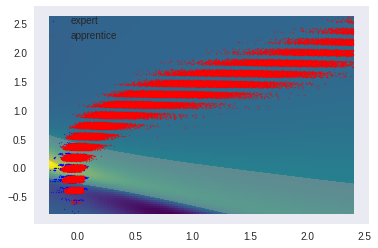

      51 | 132.0158 |  79.5968 |      132 |    22071 |  2604185 |   0.3759 |  -0.2609 |   0.9329 |   0.0205 |   0.0050 |   0.0094 |   0.0130 |        0 |   0.1658 |   0.0092 |   1.7617 |        0 |   1.0621 |   0.8339 |   0.8902 |   0.7777 |          |        0 |   0.6029 |   0.6029 |   0.0000 |   7.8306 |   4.9831 |   3.4313 | 997.9753
      52 | 138.9278 |  51.3413 |      138 |    22431 |  2654199 |   0.3789 |  -3.8018 |   0.8996 |   0.0267 |   0.0087 |   0.0092 |   0.0221 |        0 |   0.1609 |   0.0092 |   1.7046 |        0 |   0.8983 |   0.7710 |   0.9223 |   0.6197 |          |        0 |   0.3696 |   0.3696 |   0.0000 |   7.9349 |   5.0071 |   3.8451 | 1017.1059
      53 | 147.3794 |  35.7564 |      147 |    22771 |  2704308 |   0.3729 |  -9.7633 |   0.8207 |   0.0150 |   0.0102 |   0.0096 |   0.0267 |        0 |   0.1483 |   0.0090 |   1.5899 |        0 |   0.8501 |   0.7559 |   0.9351 |   0.5768 |          |        0 |   0.2426 |   0.2426 |   0.0000 |   7.9204 |   5.0564 |   

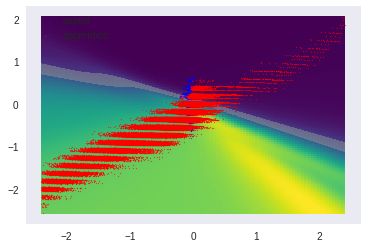

      61 | 177.7411 | 618.0238 |      177 |    24731 |  3105274 |   0.3664 |  -0.0148 |   0.7590 |   0.0244 |   0.0041 |   0.0093 |   0.0059 |        0 |   0.2407 |   0.0097 |   1.5031 |        0 |   3.6908 |   0.5022 |   0.0278 |   0.9766 |          |        0 |   3.4771 |   3.4771 |   0.0000 |   7.9607 |   5.0253 |   3.7637 | 1187.5106
      62 | 158.1893 | 532.3518 |      158 |    25048 |  3155420 |   0.3770 |   0.1573 |   0.8659 |   0.0360 |   0.0022 |   0.0055 |   0.0057 |        0 |   0.1473 |   0.0094 |   0.4684 |        0 |   3.5771 |   0.4928 |   0.0097 |   0.9760 |          |        0 |   3.3653 |   3.3653 |   0.0000 |   7.9320 |   5.4134 |   3.8273 | 1207.0793
      63 | 151.6394 | 453.3062 |      151 |    25378 |  3205461 |   0.3567 |   0.3540 |   0.8998 |   0.0358 |   0.0023 |   0.0082 |   0.0028 |        0 |   0.1015 |   0.0098 |   0.5003 |        0 |   3.2020 |   0.4914 |   0.0064 |   0.9763 |          |        0 |   2.9894 |   2.9894 |   0.0000 |   7.9246 |   5.0032 |  

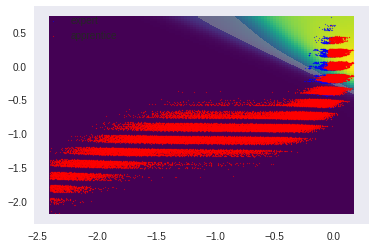

      71 | 166.2292 |  83.8697 |      166 |    28145 |  3605983 |   0.2896 |  -0.2623 |   0.6718 |   0.0393 |   0.0051 |   0.0082 |   0.0148 |        0 |   0.1377 |   0.0095 |   1.4651 |        0 |   0.6330 |   0.9113 |   0.8358 |   0.9868 |          |        0 |   0.5045 |   0.5045 |   0.0000 |   7.7984 |   4.9601 |   3.8136 | 1379.4650
      72 | 179.9820 |  93.8243 |      179 |    28423 |  3656018 |   0.2788 |   0.0848 |   0.5687 |   0.0256 |   0.0045 |   0.0087 |   0.0124 |        0 |   0.1190 |   0.0095 |   1.2675 |        0 |   0.6460 |   0.9077 |   0.8311 |   0.9843 |          |        0 |   0.5213 |   0.5213 |   0.0000 |   7.7373 |   5.0252 |   3.9138 | 1398.5045
      73 | 200.2760 |  99.9590 |      200 |    28673 |  3706087 |   0.2779 |   0.1900 |   0.4583 |   0.0315 |   0.0060 |   0.0079 |   0.0162 |        0 |   0.1009 |   0.0094 |   1.0793 |        0 |   0.6244 |   0.9101 |   0.8381 |   0.9820 |          |        0 |   0.4991 |   0.4991 |   0.0000 |   7.8731 |   4.9875 |  

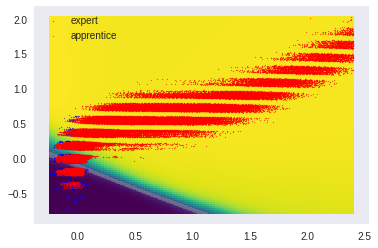

      81 | 191.6015 | 631.2809 |      191 |    30173 |  4106809 |   0.2249 |   0.1454 |   0.8832 |   0.0663 |   0.0016 |   0.0061 |   0.0028 |        0 |   0.1296 |   0.0099 |   0.5924 |        0 |   3.7045 |   0.4523 |   0.0046 |   0.9000 |          |        0 |   3.2948 |   3.2948 |   0.0000 |   7.8865 |   5.3697 |   3.7898 | 1571.9409
      82 | 187.7603 | 516.4070 |      187 |    30440 |  4156941 |   0.2357 |   0.3899 |   0.8842 |   0.0568 |   0.0016 |   0.0071 |   0.0019 |        0 |   0.1180 |   0.0097 |   0.9842 |        0 |   3.1301 |   0.4735 |   0.0020 |   0.9450 |          |        0 |   2.7504 |   2.7504 |   0.0000 |   7.8925 |   5.0686 |   3.9788 | 1591.2448
      83 | 190.2319 | 409.7463 |      190 |    30703 |  4206972 |   0.2191 |   0.6175 |   0.9106 |   0.0380 |   0.0020 |   0.0088 |   0.0061 |        0 |   0.1471 |   0.0099 |   1.5209 |        0 |   2.4989 |   0.4868 |   0.0003 |   0.9733 |          |        0 |   2.1539 |   2.1539 |   0.0000 |   7.8335 |   5.0992 |  

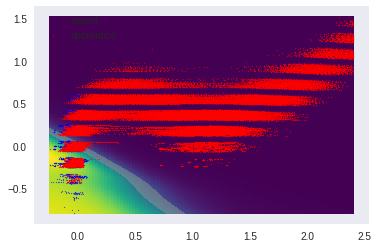

      91 | 358.9500 |  38.0201 |      358 |    32372 |  4608242 |   0.2248 |  -7.3102 |   0.4661 |   0.0187 |   0.0039 |   0.0096 |   0.0096 |        0 |   0.1259 |   0.0090 |   1.3839 |        0 |   0.6310 |   0.8553 |   0.9508 |   0.7598 |          |        0 |   0.1059 |   0.1059 |   0.0000 |   7.9162 |   5.3878 |   3.8120 | 1764.3786
      92 | 489.1359 |  43.0834 |      489 |    32475 |  4658623 |   0.2370 |  -5.4879 |   0.4507 |   0.0244 |   0.0038 |   0.0097 |   0.0118 |        0 |   0.1015 |   0.0089 |   1.1295 |        0 |   0.5338 |   0.9041 |   0.9583 |   0.8499 |          |        0 |   0.0881 |   0.0881 |   0.0000 |   7.9258 |   5.3335 |   3.8379 | 1783.8416
      93 | 806.6452 |  50.9261 |      806 |    32537 |  4708635 |   0.2399 |  -4.6661 |   0.4727 |   0.0192 |   0.0040 |   0.0094 |   0.0160 |        0 |   0.0753 |   0.0089 |   0.8603 |        0 |   0.3949 |   0.9565 |   0.9707 |   0.9423 |          |        0 |   0.0631 |   0.0631 |   0.0000 |   7.8587 |   5.4439 |  

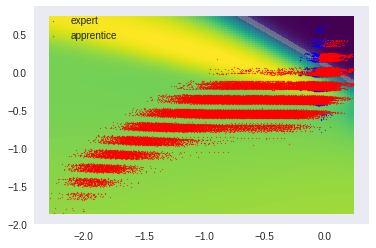

     101 | 225.8378 | 845.7930 |      225 |    33558 |  5109961 |   0.2631 |  -0.2049 |   0.8501 |   0.0265 |   0.0021 |   0.0093 |   0.0031 |        0 |   0.2102 |   0.0095 |   1.1126 |        0 |   3.9961 |   0.4609 |   0.0283 |   0.8936 |          |        0 |   3.7451 |   3.7451 |   0.0000 |   7.8535 |   5.3288 |   3.9539 | 1955.3794
     102 | 216.7879 | 720.9489 |      216 |    33789 |  5160039 |   0.2839 |  -0.0323 |   0.9065 |   0.0166 |   0.0026 |   0.0097 |   0.0062 |        0 |   0.1361 |   0.0095 |   0.2646 |        0 |   3.6048 |   0.4625 |   0.0204 |   0.9045 |          |        0 |   3.3256 |   3.3256 |   0.0000 |   7.9184 |   5.0539 |   3.8007 | 1974.5219
     103 | 215.5236 | 598.9649 |      215 |    34022 |  5210256 |   0.2794 |   0.2137 |   0.9134 |   0.0358 |   0.0014 |   0.0063 |   0.0039 |        0 |   0.1005 |   0.0100 |   0.5891 |        0 |   3.0582 |   0.4734 |   0.0178 |   0.9290 |          |        0 |   2.7791 |   2.7791 |   0.0000 |   7.9119 |   5.0799 |  

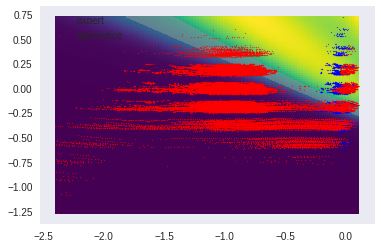

     111 | 1000.0000 | 274.5231 |     1000 |    35206 |  5611862 |   0.2589 |  -0.1870 |   0.3691 |   0.0208 |   0.0079 |   0.0091 |   0.0295 |        0 |   0.0984 |   0.0097 |   1.0823 |        0 |   0.5411 |   0.9607 |   0.9513 |   0.9700 |          |        0 |   0.2745 |   0.2745 |   0.0000 |   7.8641 |   4.9978 |   3.3930 | 2146.2867
     112 | 1000.0000 | 316.6857 |     1000 |    35256 |  5661862 |   0.2454 |   0.0300 |   0.2886 |   0.0246 |   0.0098 |   0.0096 |   0.0390 |        0 |   0.0754 |   0.0098 |   0.8455 |        0 |   0.6070 |   0.9294 |   0.9233 |   0.9354 |          |        0 |   0.3167 |   0.3167 |   0.0000 |   7.7911 |   5.0496 |   3.2478 | 2164.7089
     113 | 1000.0000 | 419.6887 |     1000 |    35306 |  5711862 |   0.2358 |   0.1772 |   0.3540 |   0.0226 |   0.0121 |   0.0094 |   0.0499 |        0 |   0.0415 |   0.0096 |   0.4882 |        0 |   0.7469 |   0.8701 |   0.8437 |   0.8965 |          |        0 |   0.4197 |   0.4197 |   0.0000 |   7.8175 |   4.9808 

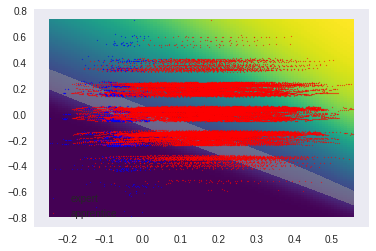

     121 | 1000.0000 | 2226.9498 |     1000 |    35706 |  6111862 |   0.2218 |   0.5646 |   0.8932 |   0.0186 |   0.0181 |   0.0099 |   0.0945 |        0 |   0.1645 |   0.0102 |   1.5917 |        0 |   3.1549 |   0.3528 |   0.0147 |   0.6909 |          |        0 |   2.2269 |   2.2269 |   0.0000 |   7.8450 |   5.3783 |   3.1351 | 2331.3540
     122 | 1000.0000 | 2150.3449 |     1000 |    35756 |  6161862 |   0.2283 |   0.6285 |   0.9087 |   0.0194 |   0.0151 |   0.0097 |   0.0835 |        0 |   0.0849 |   0.0101 |   0.8101 |        0 |   2.9654 |   0.3829 |   0.0033 |   0.7626 |          |        0 |   2.1503 |   2.1503 |   0.0000 |   7.7958 |   5.4543 |   3.2009 | 2350.1384
     123 | 1000.0000 | 1877.8198 |     1000 |    35806 |  6211862 |   0.2229 |   0.7316 |   0.9290 |   0.0151 |   0.0154 |   0.0098 |   0.0831 |        0 |   0.0273 |   0.0072 |   0.2463 |        0 |   2.5747 |   0.4202 |   0.0457 |   0.7946 |          |        0 |   1.8778 |   1.8778 |   0.0000 |   7.8286 |   5.35

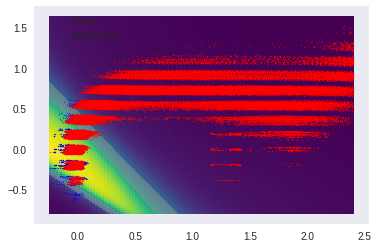

     131 | 189.4205 |  55.1484 |      189 |    36676 |  6612096 |   0.2809 |  -7.2047 |   0.9231 |   0.0345 |   0.0015 |   0.0069 |   0.0029 |        0 |   0.2882 |   0.0098 |   2.9801 |        0 |   0.6421 |   0.9179 |   0.8754 |   0.9604 |          |        0 |   0.2911 |   0.2911 |   0.0000 |   7.9144 |   5.0134 |   4.0486 | 2522.7124
     132 | 179.8530 |  52.0618 |      179 |    36955 |  6662275 |   0.2705 |  -7.1787 |   0.8922 |   0.0331 |   0.0010 |   0.0074 |   0.0017 |        0 |   0.2730 |   0.0098 |   2.8263 |        0 |   0.5804 |   0.9224 |   0.8707 |   0.9741 |          |        0 |   0.2895 |   0.2895 |   0.0000 |   7.8956 |   5.3037 |   3.8873 | 2542.1505
     133 | 177.9537 |  57.2487 |      177 |    37236 |  6712280 |   0.2423 |  -5.4060 |   0.8532 |   0.0549 |   0.0011 |   0.0083 |   0.0020 |        0 |   0.2537 |   0.0098 |   2.6249 |        0 |   0.5627 |   0.9148 |   0.8476 |   0.9819 |          |        0 |   0.3217 |   0.3217 |   0.0000 |   7.9399 |   5.4620 |  

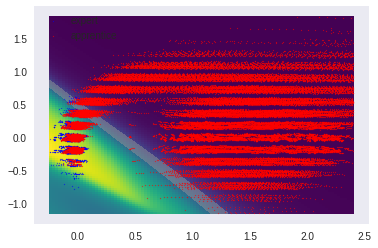

     141 | 772.0615 |  95.2612 |      772 |    39178 |  7113447 |   0.2373 |  -3.0168 |   0.6435 |   0.0250 |   0.0063 |   0.0073 |   0.0170 |        0 |   0.0654 |   0.0099 |   0.7294 |        0 |   0.2127 |   0.9837 |   0.9710 |   0.9965 |          |        0 |   0.1234 |   0.1234 |   0.0000 |   7.9541 |   5.6546 |   3.9980 | 2720.0239
     142 | 944.7736 | 114.0561 |      944 |    39231 |  7163520 |   0.2193 |  -1.7342 |   0.6518 |   0.0296 |   0.0092 |   0.0094 |   0.0333 |        0 |   0.0442 |   0.0098 |   0.5148 |        0 |   0.2064 |   0.9857 |   0.9752 |   0.9963 |          |        0 |   0.1207 |   0.1207 |   0.0000 |   7.8762 |   5.5482 |   3.6183 | 2739.4194
     143 | 985.7059 | 155.8134 |      985 |    39282 |  7213791 |   0.2108 |   0.1103 |   0.5409 |   0.0197 |   0.0151 |   0.0093 |   0.0570 |        0 |   0.0237 |   0.0095 |   0.3197 |        0 |   0.2409 |   0.9845 |   0.9736 |   0.9954 |          |        0 |   0.1581 |   0.1581 |   0.0000 |   7.9861 |   5.6200 |  

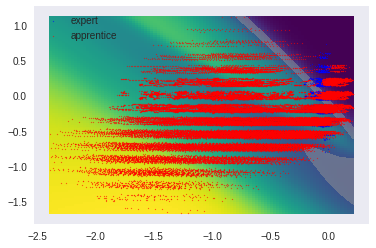

     151 | 385.3923 | 610.9352 |      385 |    40170 |  7616885 |   0.2318 |   0.2842 |   0.2685 |   0.0234 |   0.0090 |   0.0097 |   0.0163 |        0 |   0.0468 |   0.0096 |   0.3192 |        0 |   2.1768 |   0.5124 |   0.3464 |   0.6784 |          |        0 |   1.5852 |   1.5852 |   0.0000 |   7.9783 |   5.4401 |   4.0923 | 2916.0470
     152 | 798.0952 | 1062.7944 |      798 |    40233 |  7667165 |   0.2382 |   0.3410 |   0.3547 |   0.0143 |   0.0073 |   0.0096 |   0.0139 |        0 |   0.0120 |   0.0095 |   0.0942 |        0 |   1.9843 |   0.5870 |   0.4426 |   0.7315 |          |        0 |   1.3317 |   1.3317 |   0.0000 |   8.0057 |   5.4521 |   4.0587 | 2935.9307
     153 | 993.3922 | 983.6637 |      993 |    40284 |  7717828 |   0.2328 |   0.5544 |   0.6419 |   0.0154 |   0.0070 |   0.0098 |   0.0191 |        0 |   0.0378 |   0.0099 |   0.4615 |        0 |   1.6091 |   0.6943 |   0.5645 |   0.8241 |          |        0 |   0.9902 |   0.9902 |   0.0000 |   8.0142 |   5.3971 | 

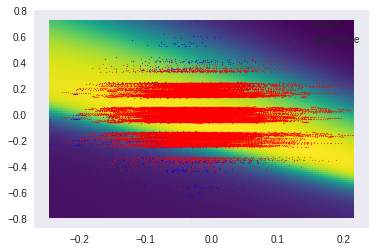

     161 | 1000.0000 | 542.6010 |     1000 |    40684 |  8117828 |   0.2541 |   0.8540 |   0.9874 |   0.0146 |   0.0094 |   0.0099 |   0.0456 |        0 |   0.0441 |   0.0098 |   0.5258 |        0 |   1.6164 |   0.5000 |   1.0000 |   0.0000 |          |        0 |   0.5426 |   0.5426 |   0.0000 |   7.8128 |   5.3405 |   3.1446 | 3104.6035
     162 | 1000.0000 | 463.7555 |     1000 |    40734 |  8167828 |   0.2666 |   0.8247 |   0.9796 |   0.0133 |   0.0069 |   0.0102 |   0.0386 |        0 |   0.0376 |   0.0097 |   0.4645 |        0 |   1.6618 |   0.5000 |   1.0000 |   0.0000 |          |        0 |   0.4638 |   0.4638 |   0.0000 |   7.7870 |   5.3387 |   3.0818 | 3123.1178
     163 | 1000.0000 | 409.2567 |     1000 |    40784 |  8217828 |   0.2649 |   0.7650 |   0.9542 |   0.0166 |   0.0050 |   0.0100 |   0.0282 |        0 |   0.0267 |   0.0097 |   0.3549 |        0 |   1.6370 |   0.5000 |   1.0000 |   0.0000 |          |        0 |   0.4093 |   0.4093 |   0.0000 |   7.7905 |   5.0178 

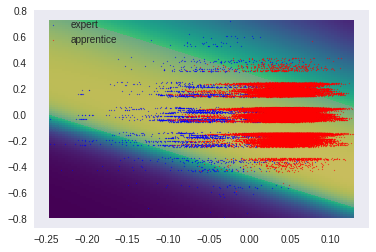

     171 | 1000.0000 | 879.2207 |     1000 |    41184 |  8617828 |   0.3059 |   0.9510 |   0.9945 |   0.0183 |   0.0066 |   0.0100 |   0.0464 |        0 |   0.0009 |   0.0009 |   0.0013 |        0 |   1.3920 |   0.5212 |   0.1227 |   0.9198 |          |        0 |   0.8792 |   0.8792 |   0.0000 |   7.8436 |   5.4306 |   2.9304 | 3290.7241
     172 | 1000.0000 | 893.8598 |     1000 |    41234 |  8667828 |   0.3077 |   0.9633 |   0.9948 |   0.0154 |   0.0107 |   0.0101 |   0.0775 |        0 |   0.0006 |   0.0005 |   0.0313 |        2 |   1.4194 |   0.4951 |   0.1094 |   0.8809 |          |        0 |   0.8939 |   0.8939 |   0.0000 |   7.8075 |   6.2208 |   2.9837 | 3310.0544
     173 | 1000.0000 | 879.5705 |     1000 |    41284 |  8717828 |   0.3078 |   0.9628 |   0.9939 |   0.0167 |   0.0089 |   0.0098 |   0.0667 |        0 |   0.0021 |   0.0104 |   0.1257 |        0 |   1.4454 |   0.4656 |   0.1501 |   0.7811 |          |        0 |   0.8796 |   0.8796 |   0.0000 |   7.8263 |   5.2664 

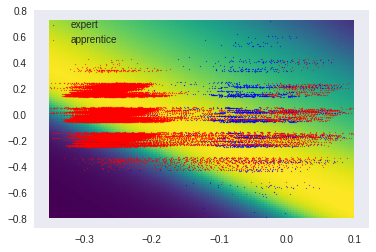

     181 | 1000.0000 | 594.1971 |     1000 |    41684 |  9117828 |   0.2620 |   0.9788 |   0.9911 |   0.0087 |   0.0082 |   0.0101 |   0.0561 |        0 |   0.0025 |   0.0025 |   0.0952 |        1 |   1.4728 |   0.5375 |   0.6357 |   0.4393 |          |        0 |   0.5942 |   0.5942 |   0.0000 |   7.8274 |   5.9782 |   3.1901 | 3481.1304
     182 | 1000.0000 | 638.5435 |     1000 |    41734 |  9167828 |   0.2630 |   0.9820 |   0.9959 |   0.0195 |   0.0069 |   0.0100 |   0.0466 |        0 |   0.0040 |   0.0099 |   0.1355 |        0 |   1.4581 |   0.5925 |   0.6430 |   0.5420 |          |        0 |   0.6385 |   0.6385 |   0.0000 |   7.6941 |   5.4721 |   3.2048 | 3499.8399
     183 | 1000.0000 | 687.0033 |     1000 |    41784 |  9217828 |   0.2625 |   0.9842 |   0.9973 |   0.0185 |   0.0047 |   0.0102 |   0.0322 |        0 |   0.0013 |   0.0025 |   0.0792 |        1 |   1.4432 |   0.5654 |   0.5758 |   0.5551 |          |        0 |   0.6870 |   0.6870 |   0.0000 |   7.7417 |   5.7953 

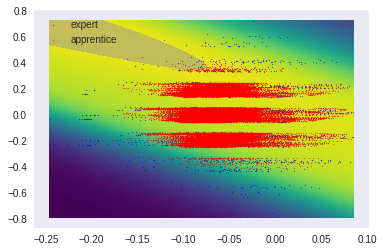

     191 | 1000.0000 | 699.1409 |     1000 |    42184 |  9617828 |   0.2314 |   0.9917 |   0.9996 |   0.0118 |   0.0021 |   0.0104 |   0.0158 |        0 |   0.0006 |   0.0026 |   0.0666 |        1 |   1.3844 |   0.5319 |   0.4830 |   0.5807 |          |        0 |   0.6991 |   0.6991 |   0.0000 |   7.8339 |   5.8543 |   3.1876 | 3672.9835
     192 | 1000.0000 | 666.2753 |     1000 |    42234 |  9667828 |   0.2399 |   0.9924 |   0.9997 |   0.0152 |   0.0025 |   0.0099 |   0.0215 |        0 |   0.0004 |   0.0006 |   0.0448 |        2 |   1.3809 |   0.5353 |   0.5982 |   0.4723 |          |        0 |   0.6663 |   0.6663 |   0.0000 |   7.7852 |   6.2232 |   2.9515 | 3692.2734
     193 | 1000.0000 | 642.5005 |     1000 |    42284 |  9717828 |   0.2322 |   0.9926 |   0.9992 |   0.0429 |   0.0021 |   0.0100 |   0.0062 |        0 |   0.0003 |   0.0006 |   0.0406 |        2 |   1.3835 |   0.5690 |   0.8294 |   0.3086 |          |        0 |   0.6425 |   0.6425 |   0.0000 |   7.8180 |   6.2595 

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
log = nn.TrainingLog( logfilename, [] )
for i in xrange(max_iter):
    iter_info = opt.step()
    log.write(iter_info, print_header=i % (20*print_freq) == 0, display=i % print_freq == 0)
    if save_freq != 0 and i % save_freq == 0 and log is not None:
        log.write_snapshot(policy, i)

    if plot_freq != 0 and i % plot_freq == 0:
        exdata_N_Doa = np.concatenate([exobs_Bstacked_Do, exa_Bstacked_Da], axis=1)
        pdata_M_Doa = np.concatenate([opt.last_sampbatch.obs.stacked, opt.last_sampbatch.a.stacked], axis=1)

        # Plot reward
        _, ax = plt.subplots()
        idx1, idx2 = 0,1
        range1 = (min(exdata_N_Doa[:,idx1].min(), pdata_M_Doa[:,idx1].min()), max(exdata_N_Doa[:,idx1].max(), pdata_M_Doa[:,idx1].max()))
        range2 = (min(exdata_N_Doa[:,idx2].min(), pdata_M_Doa[:,idx2].min()), max(exdata_N_Doa[:,idx2].max(), pdata_M_Doa[:,idx2].max()))
        reward.plot(ax, idx1, idx2, range1, range2, n=100)

        # Plot expert data
        ax.scatter(exdata_N_Doa[:,idx1], exdata_N_Doa[:,idx2], color='blue', alpha=0.5, s=1, label='expert')

        # Plot policy samples
        ax.scatter(pdata_M_Doa[:,idx1], pdata_M_Doa[:,idx2], color='red',  alpha=0.5, s=1, label='apprentice')

        ax.legend()
        plt.show()

## Evaluation : 학습된 Policy 실행시켜보기

In [0]:
def import_policy(policy_file, env_name, max_traj_len=None):
    policy_file, policy_key = util.split_h5_name(policy_file)
    print 'Loading policy parameters from %s in %s' % (policy_key, policy_file)
    with h5py.File(policy_file, 'r') as f:        
        dset = f[policy_key]
        import pprint
        pprint.pprint(dict(dset.attrs))

    # Initialize the MDP    
    print 'Loading environment', env_name
    mdp = rlgymenv.RLGymMDP(env_name)
    util.header('MDP observation space, action space sizes: %d, %d\n' % (mdp.obs_space.dim, mdp.action_space.storage_size))

    if max_traj_len is None:
        max_traj_len = mdp.env_spec.timestep_limit
    util.header('Max traj len is {}'.format(max_traj_len))

    # Initialize the policy and load its parameters
    enable_obsnorm = True
    if isinstance(mdp.action_space, policyopt.ContinuousSpace):
        policy_cfg = rl.GaussianPolicyConfig(
            hidden_spec=SIMPLE_ARCHITECTURE,
            min_stdev=0.,
            init_logstdev=0.,
            enable_obsnorm=enable_obsnorm)
        policy = rl.GaussianPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GaussianPolicy')
        
    else:
        policy_cfg = rl.GibbsPolicyConfig(
            hidden_spec=SIMPLE_ARCHITECTURE,
            enable_obsnorm=enable_obsnorm)
        policy = rl.GibbsPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GibbsPolicy')
        
    policy.load_h5(policy_file, policy_key)
    
    return policy, mdp

# If you want to load from weight file use `import_policy` function:
# key_iter=0
# policy, mdp = import_policy("CartPole-v0.h5/snapshots/iter%07d" % key_iter, 'CartPole-v0')
# Otherwise, we'll use results of training.

In [0]:
returns = []
lengths = []
images = []

sim = mdp.new_sim()
env = sim.env
n = 10

for i_traj in xrange(n):
#     print i_traj, n
    obs = env.reset()
    totalr = 0.
    l = 0
    done = False
    imgarr = []
    while not done:
        a = policy.sample_actions(obs[None], True)[0][0,0]
        obs, r, done, _ = env.step(a)
        img = env.render(mode='rgb_array')
        imgarr.append(img)
        totalr += r
        l += 1        
          
    returns.append(totalr)
    lengths.append(l)
    images.append(imgarr)
    print("-- Episode : %2d/%d | Return : %4.3f | Length : %4d "%(i_traj+1, n, totalr, l))
    
print("**** Return : Avg=%.3f , Std=%.3f"%(np.array(returns).mean(), np.array(returns).std()))

Exception AttributeError: "'Viewer' object has no attribute 'finish'" in <bound method RLGymSim.__del__ of <environments.rlgymenv.RLGymSim object at 0x7f55c1543dd0>> ignored


In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import display, HTML

def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

def plot_movie_js(image_array):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(IPython_display.display_animation(anim))


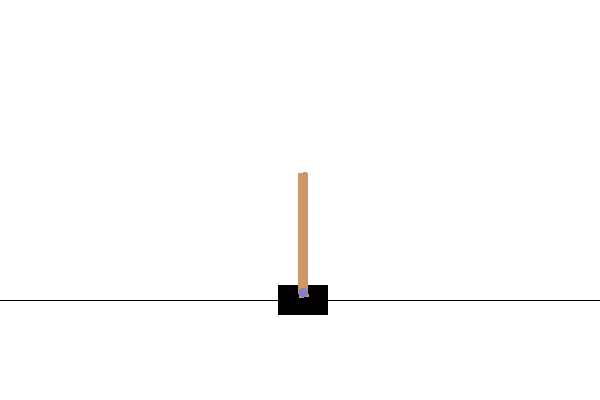
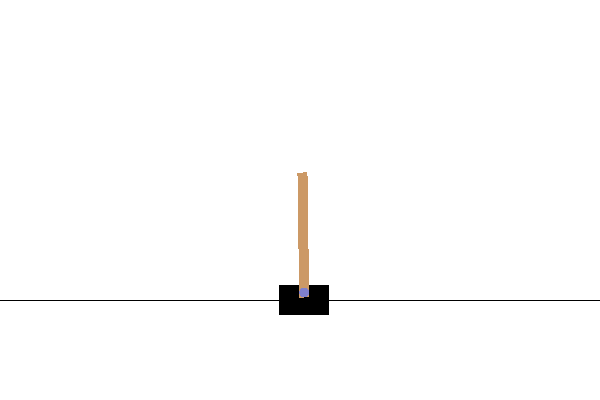
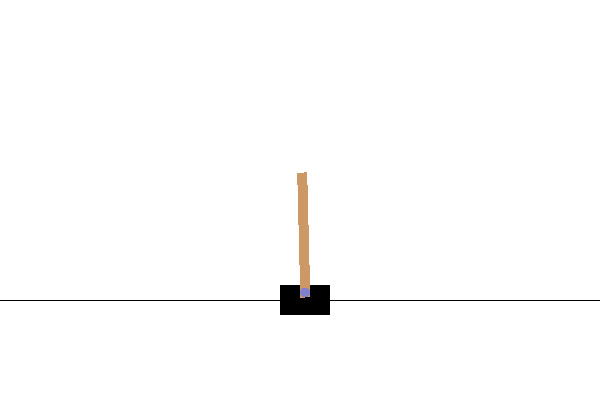
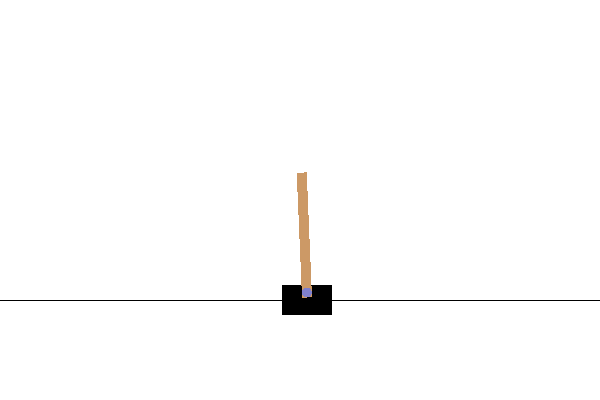
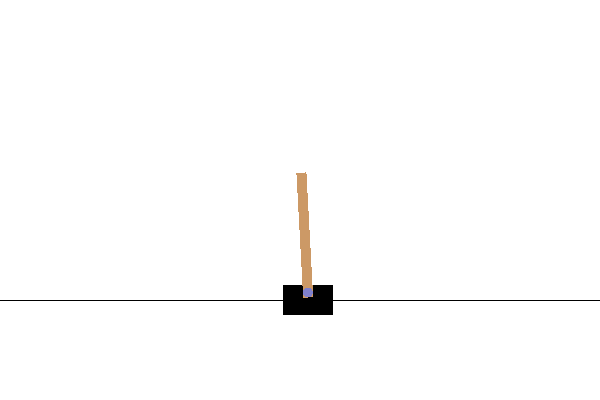
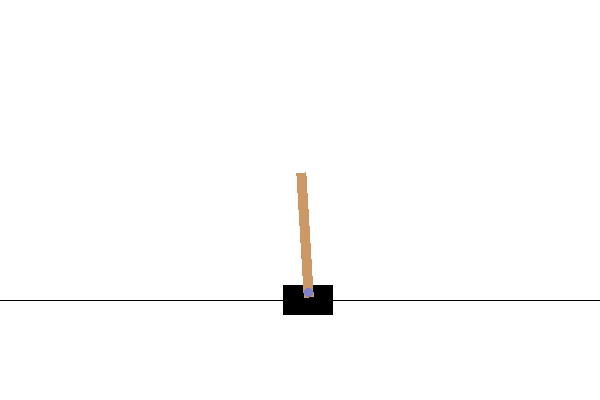
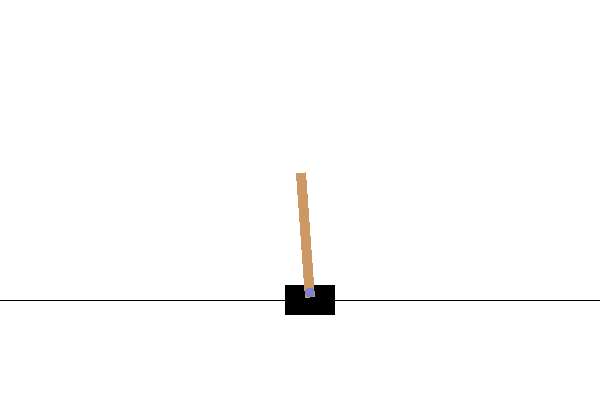
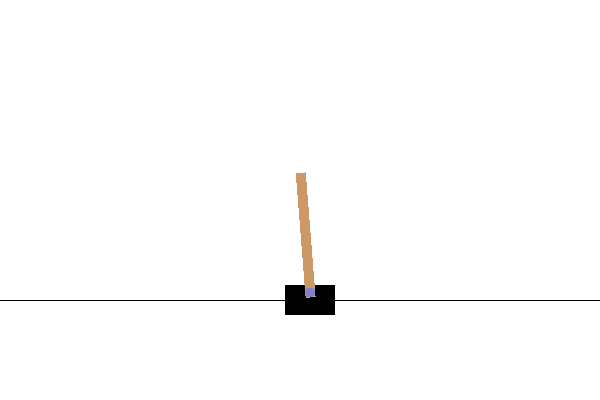
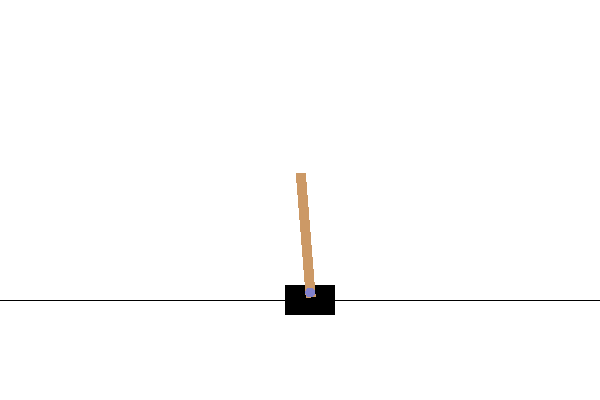
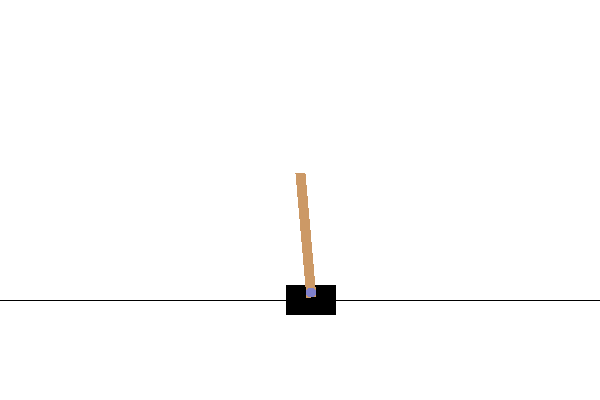
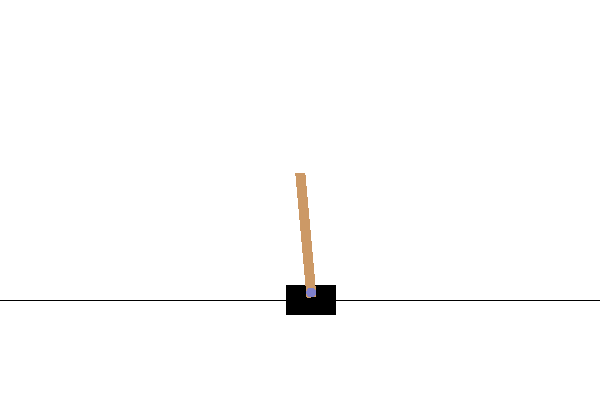
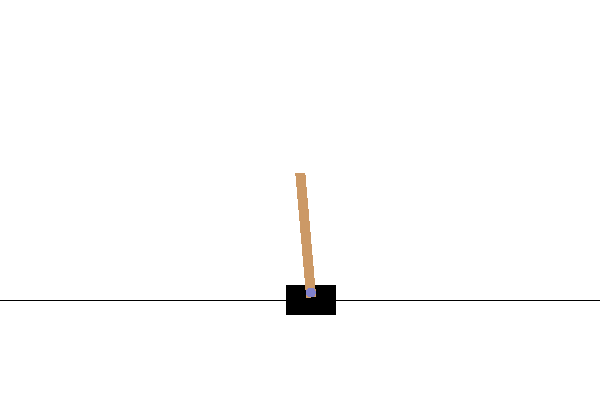
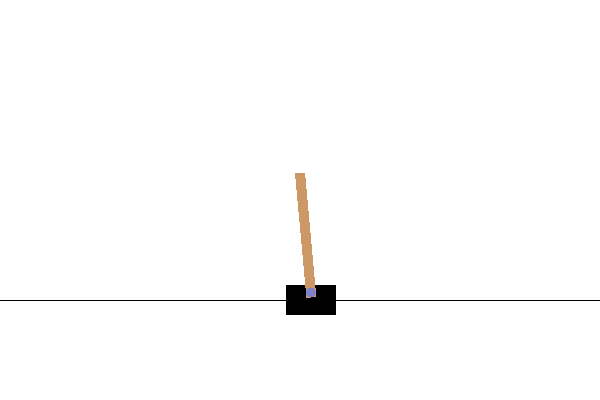
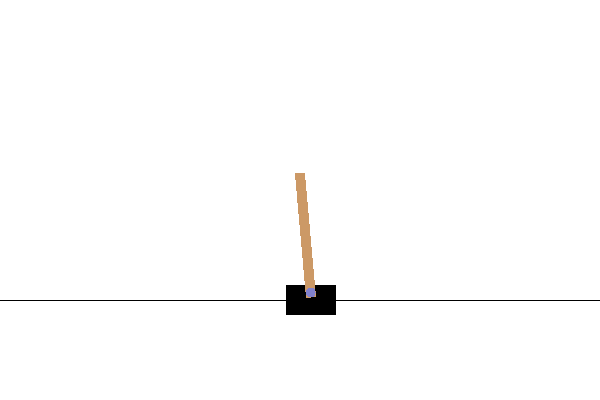
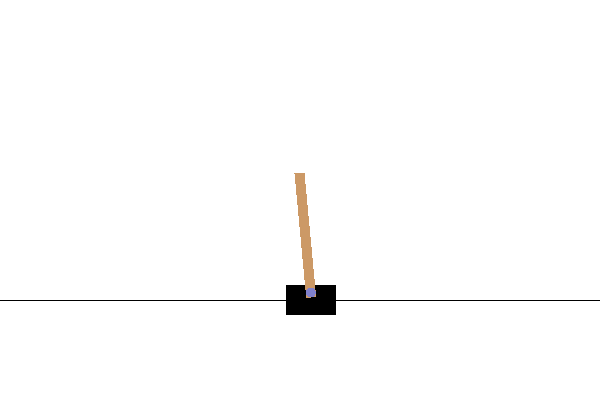
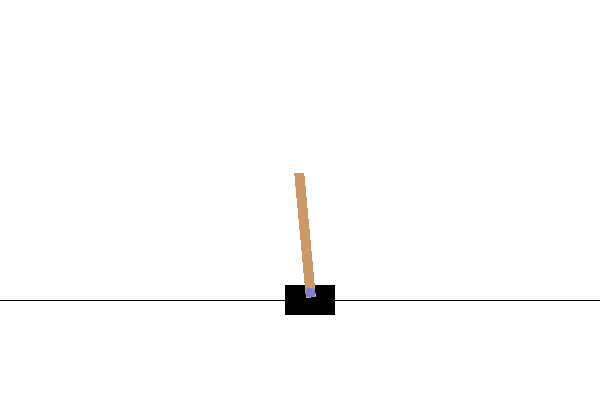
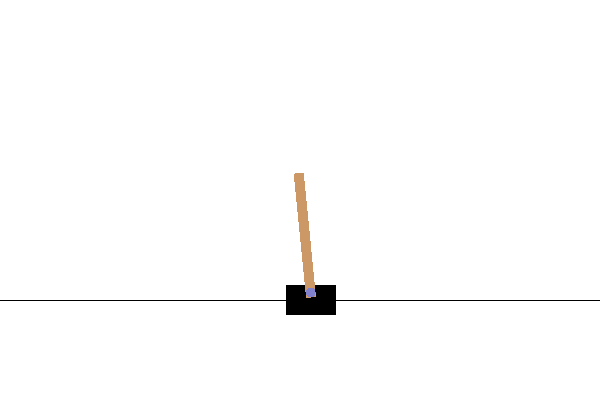
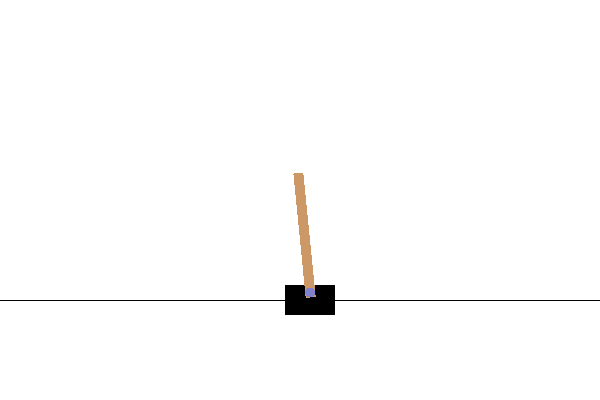
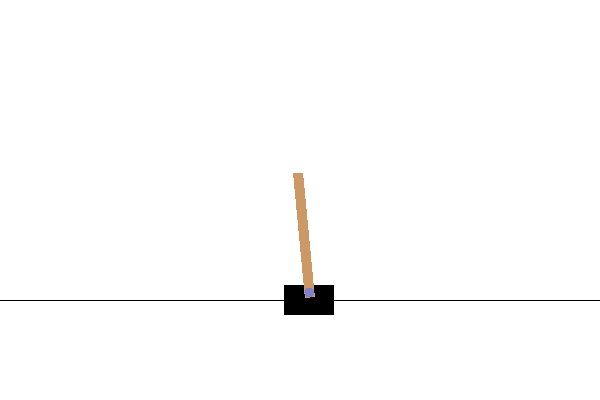
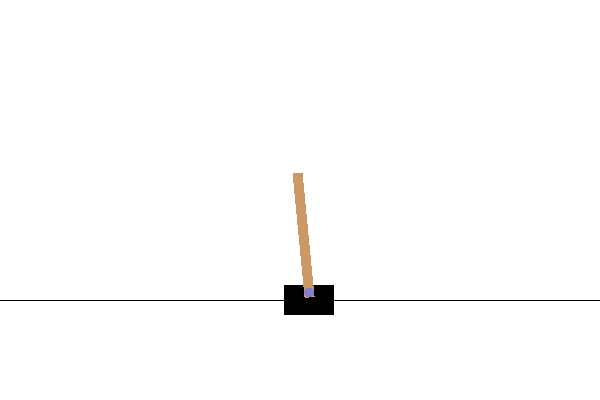
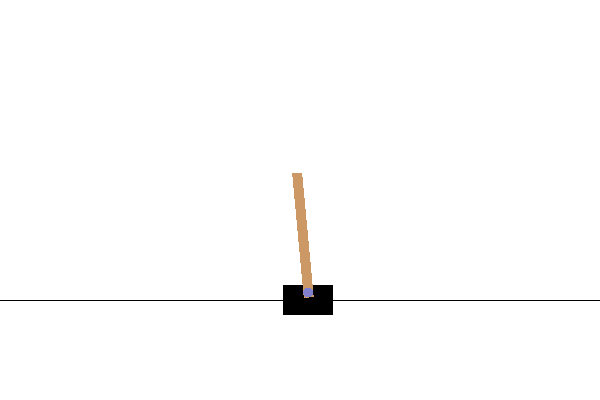
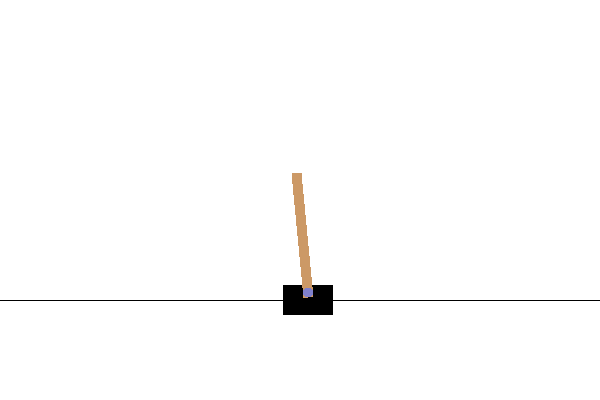
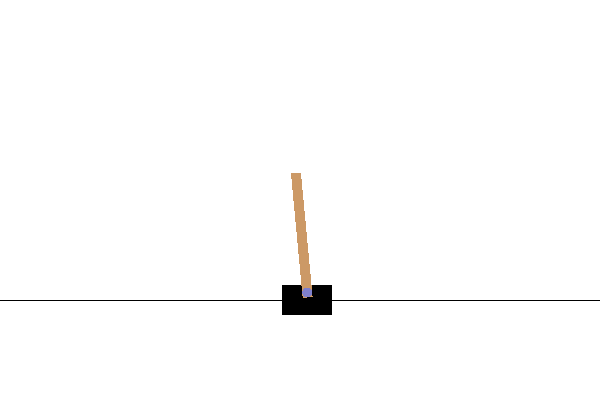
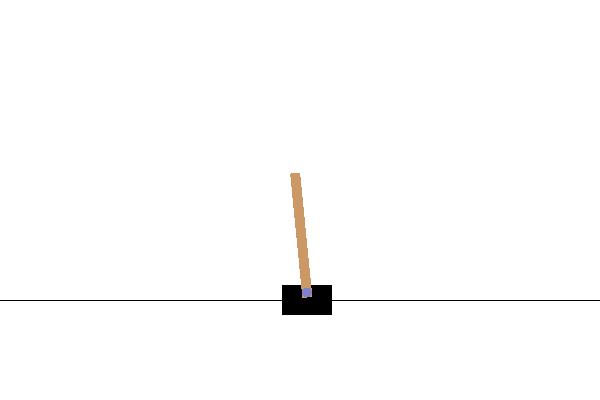
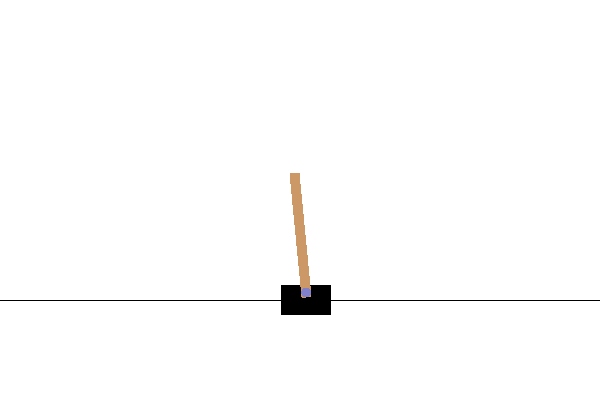
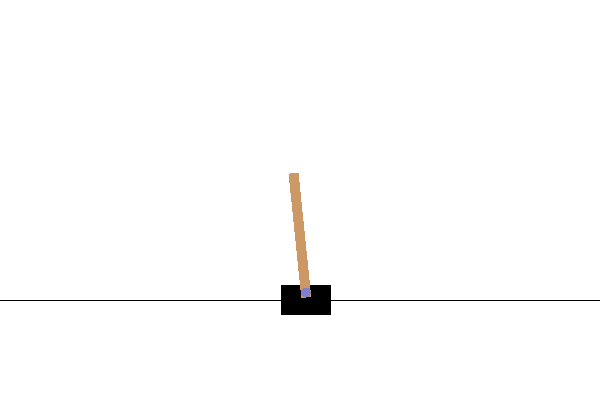
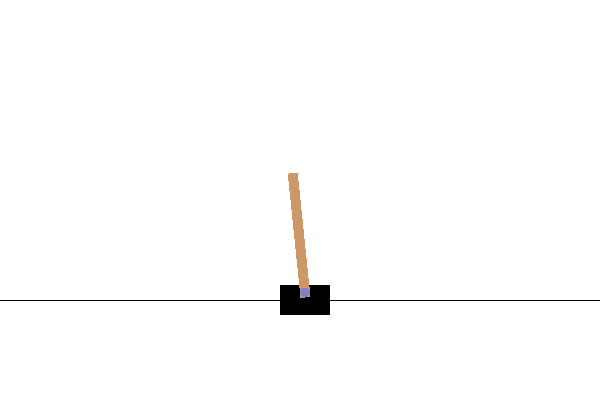
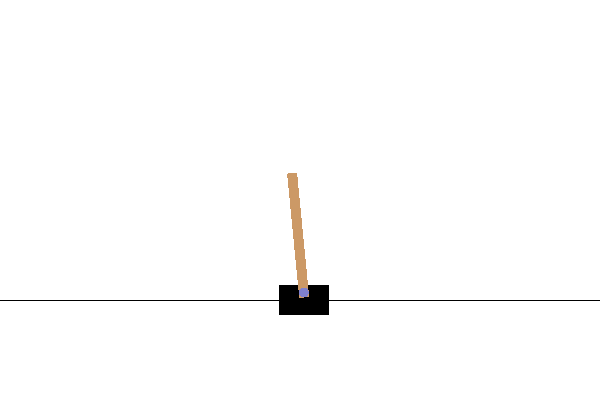
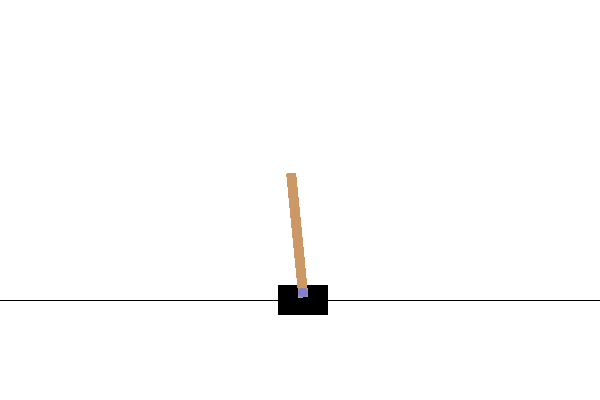
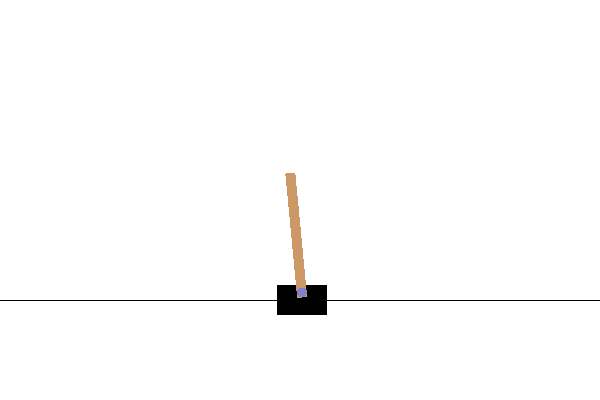
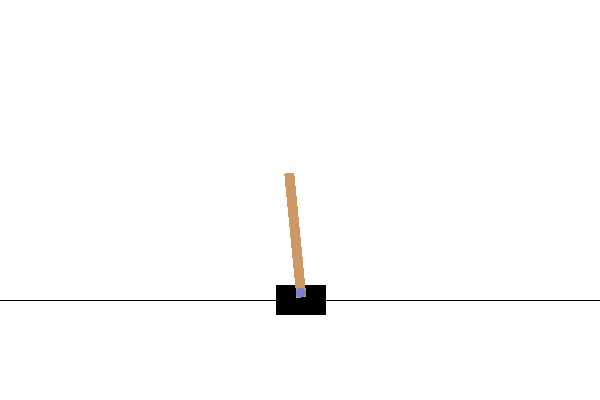
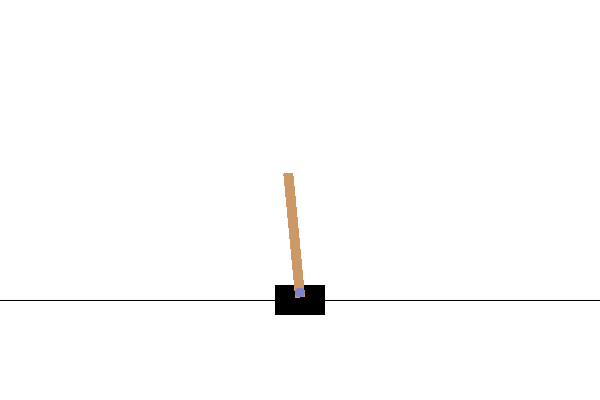
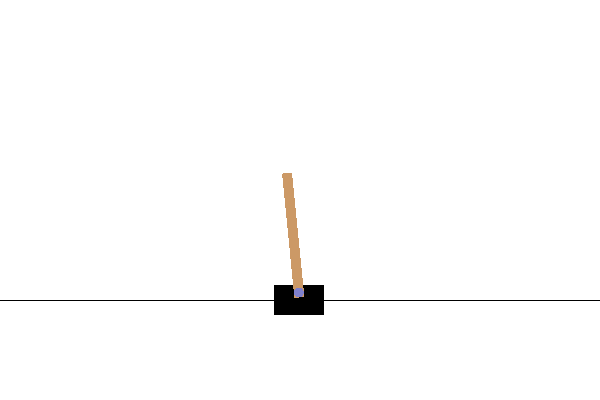
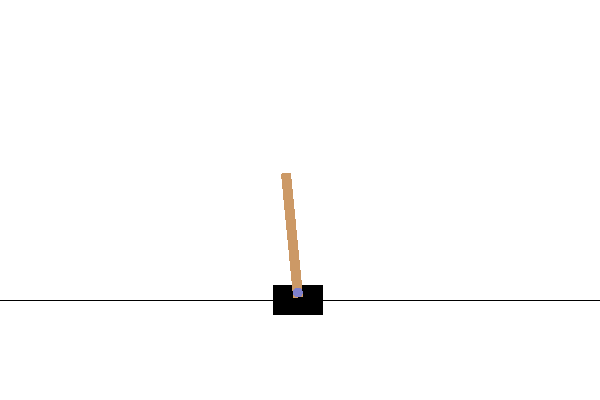
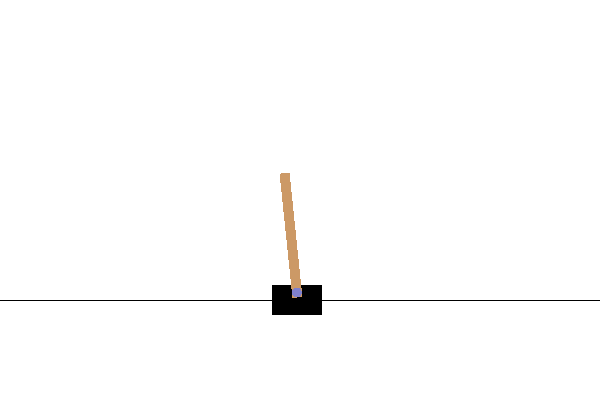
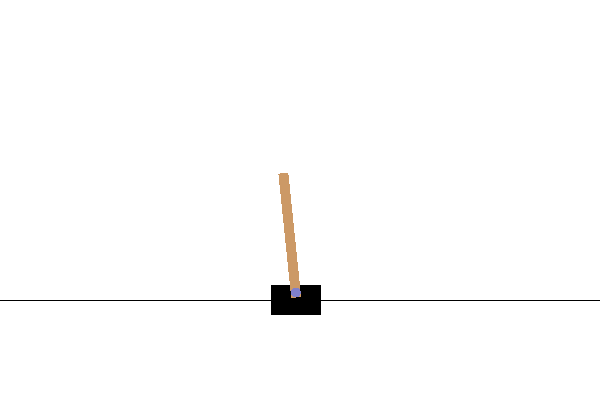
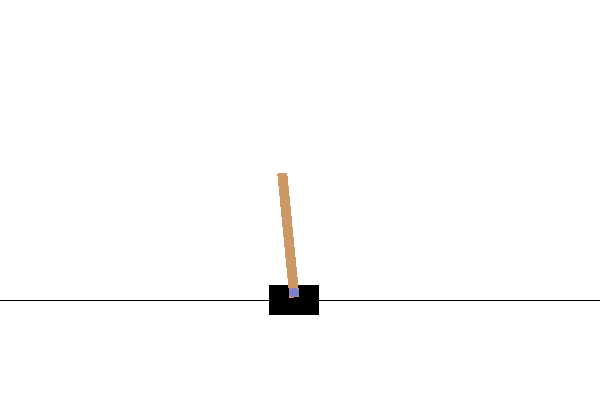
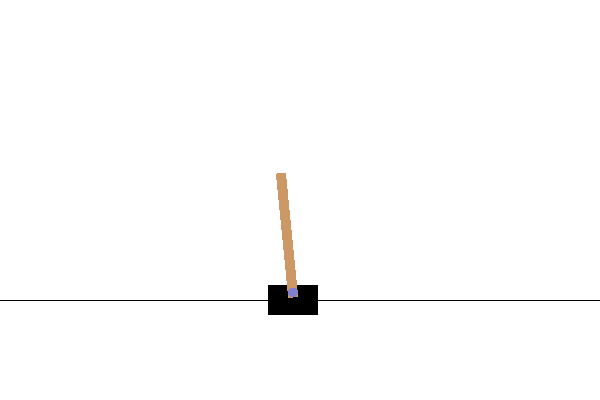
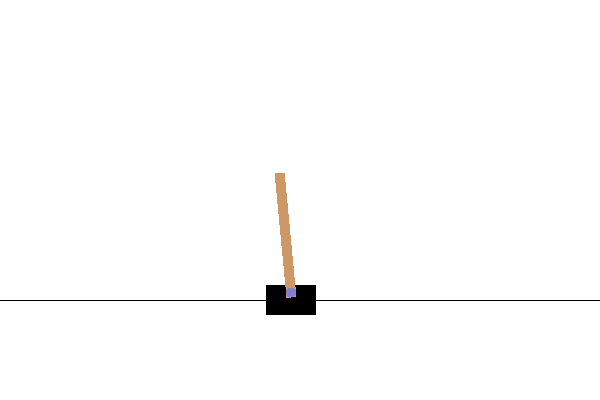
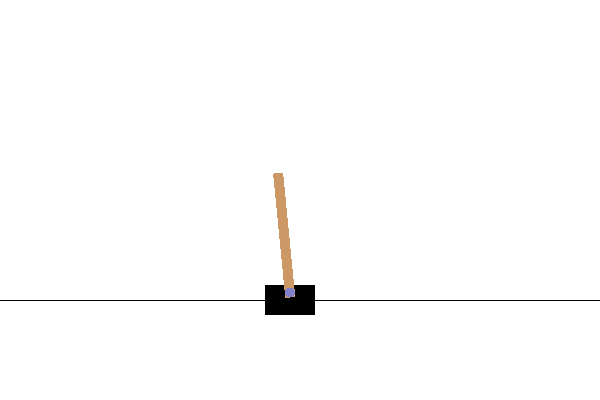
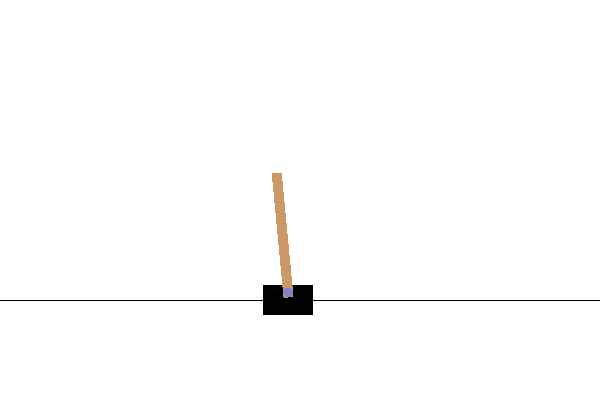
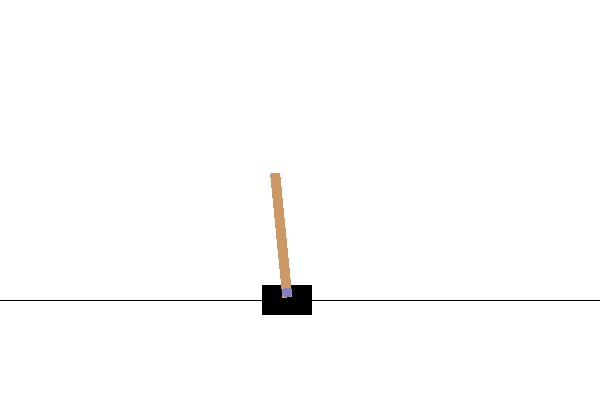
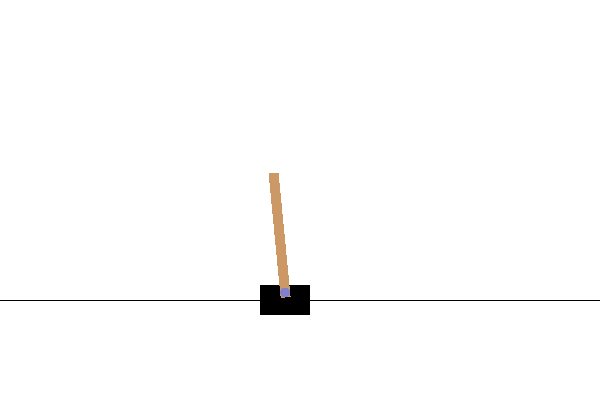
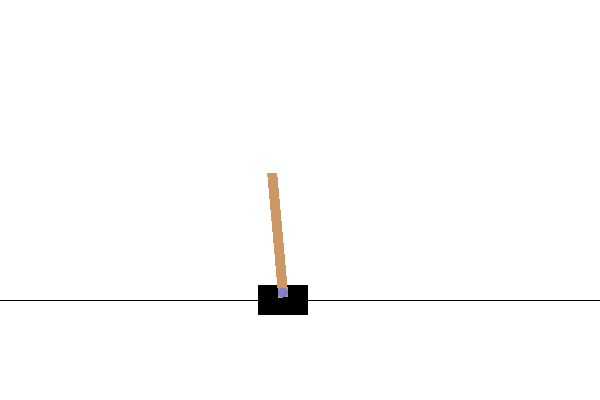
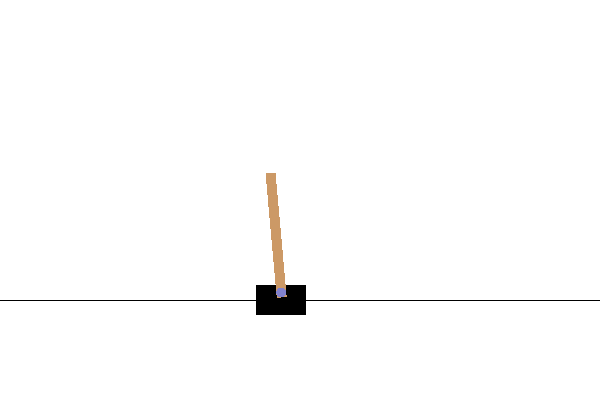
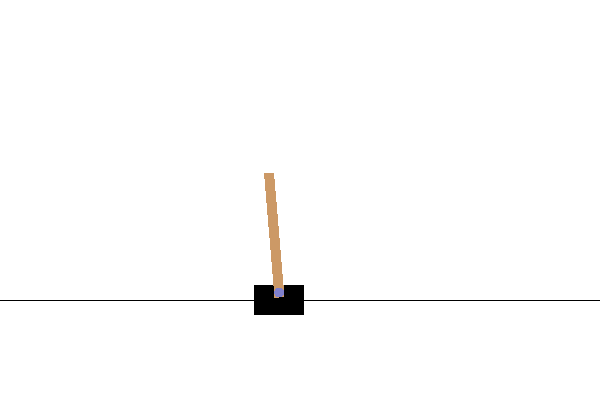
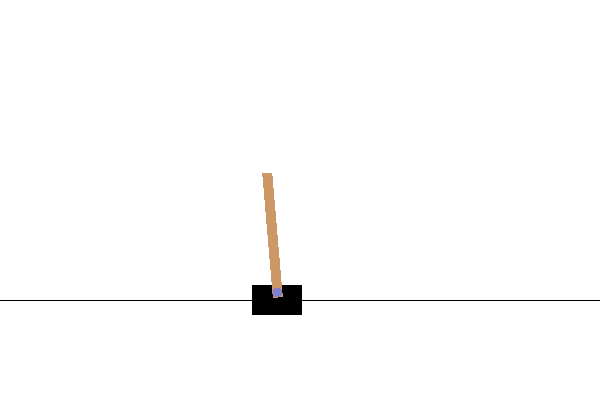
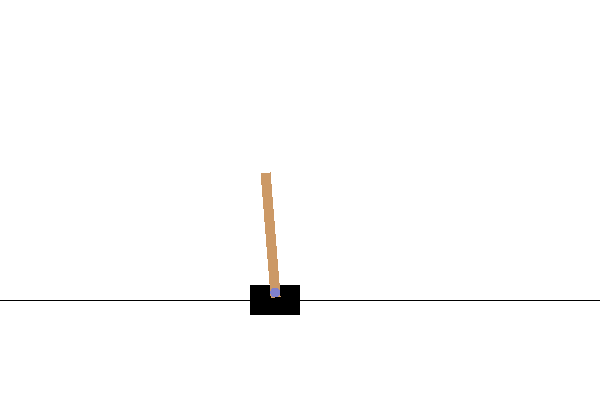
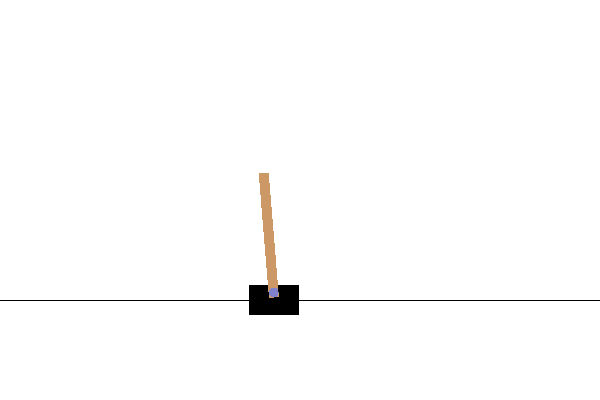
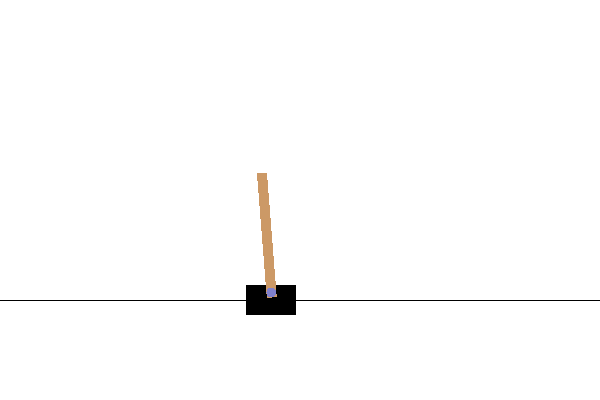
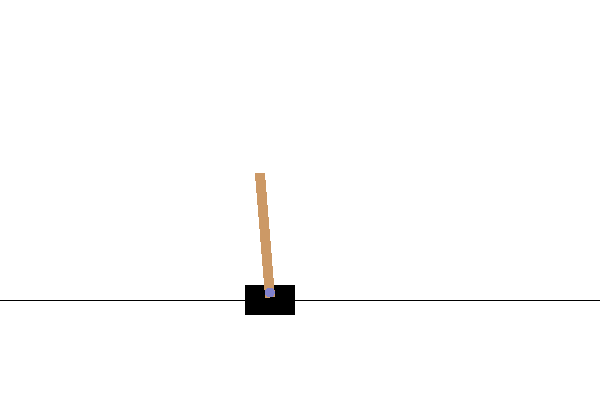
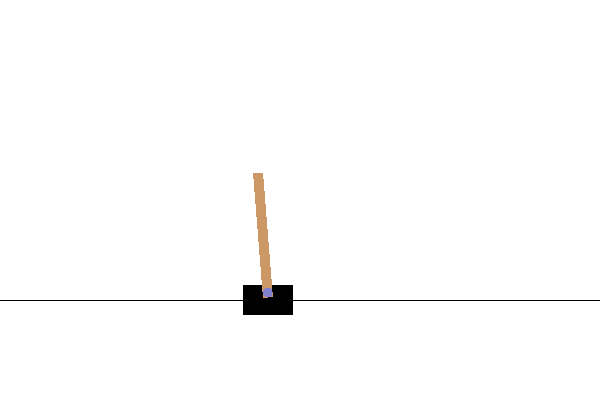
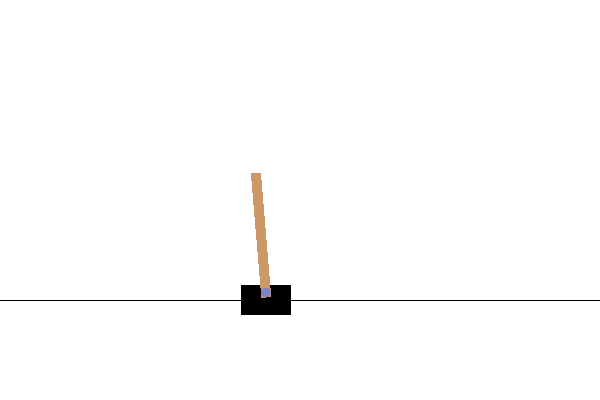
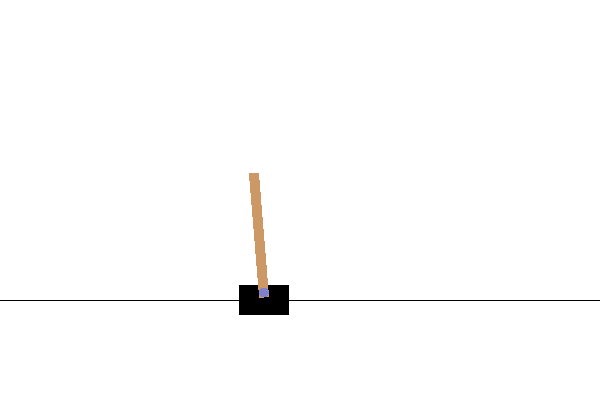
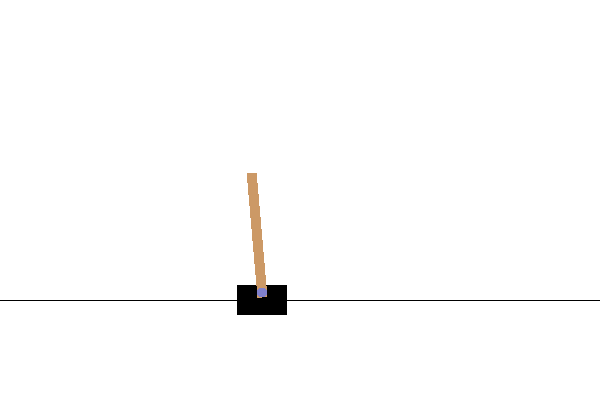
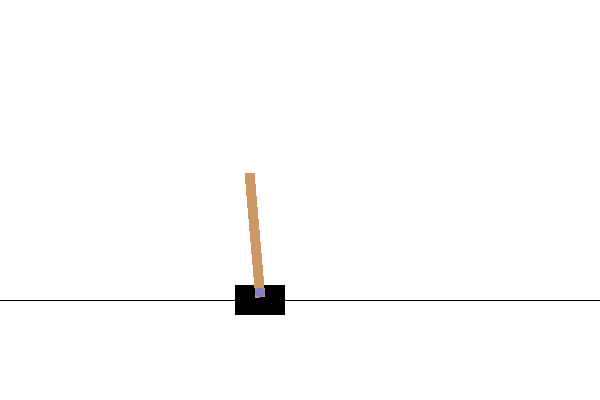
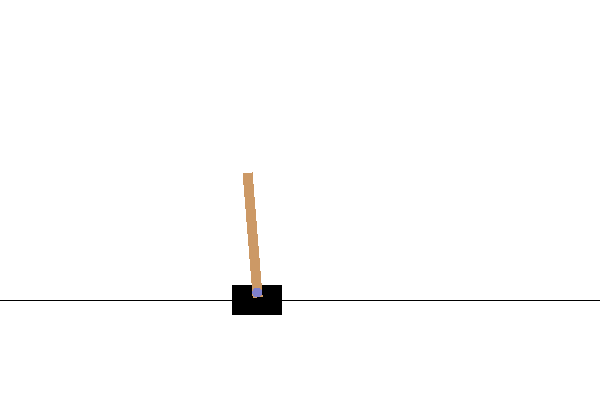
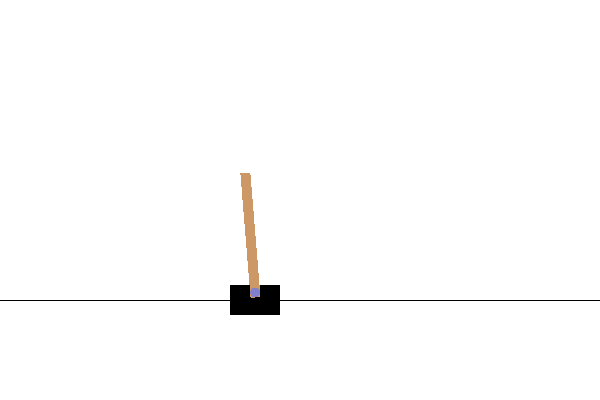
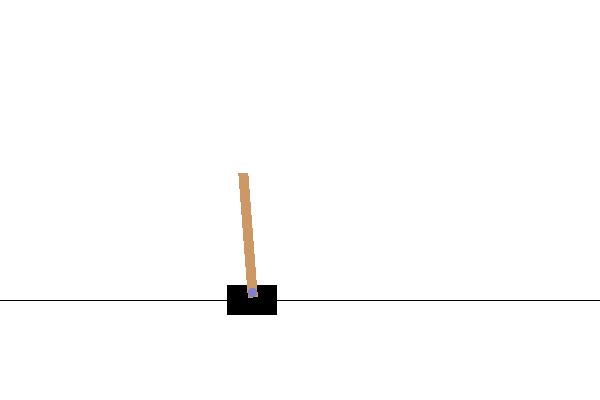
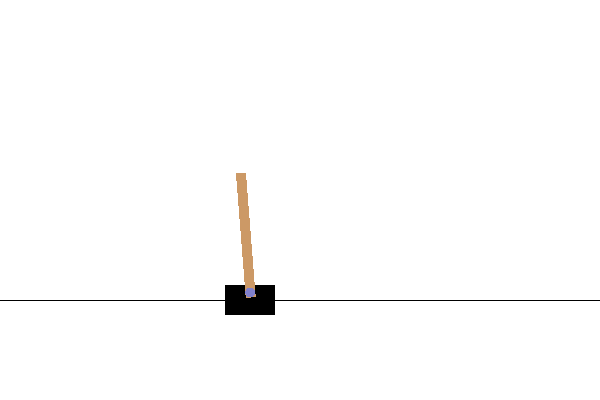
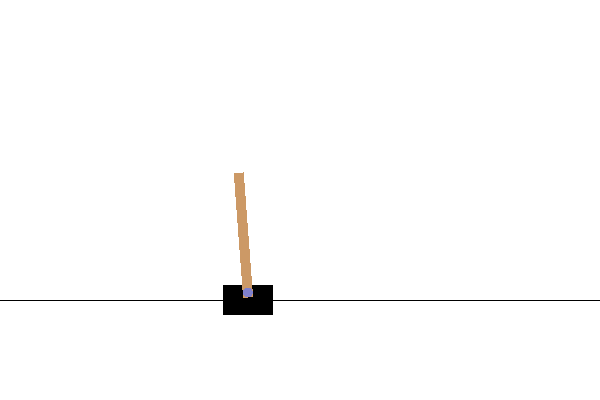
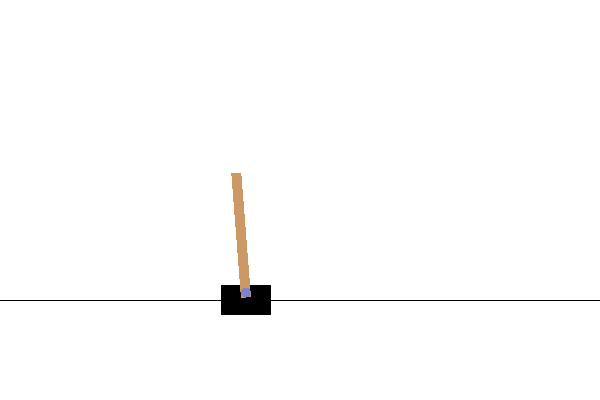
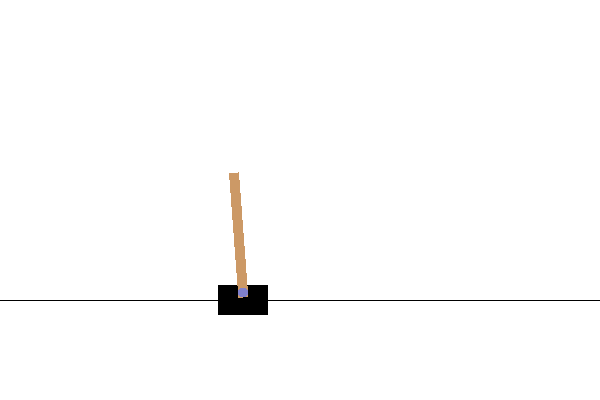
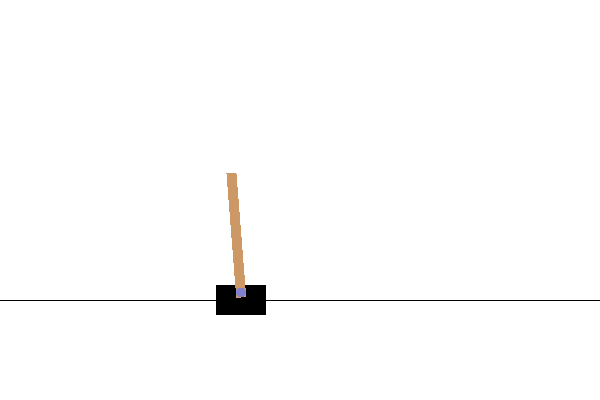
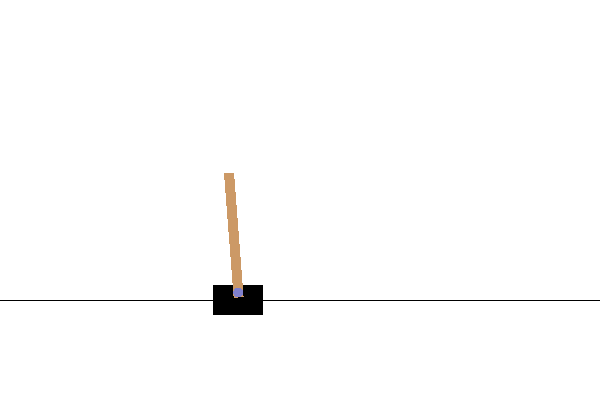
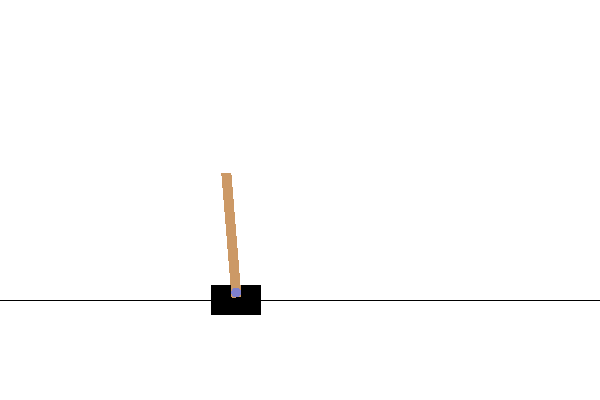
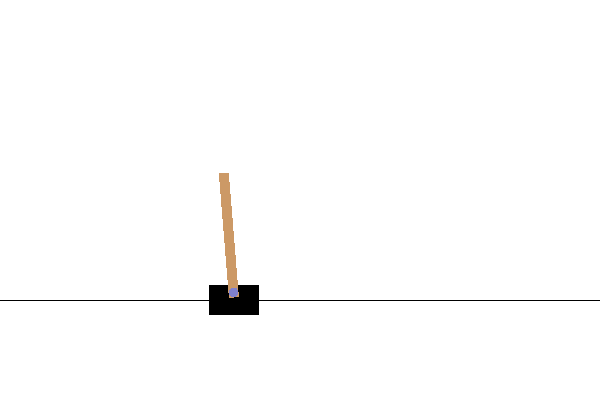
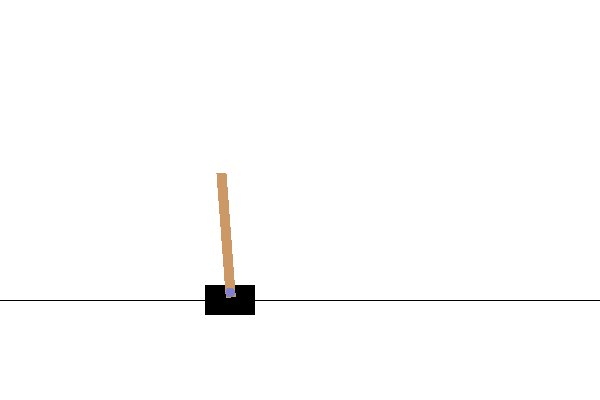
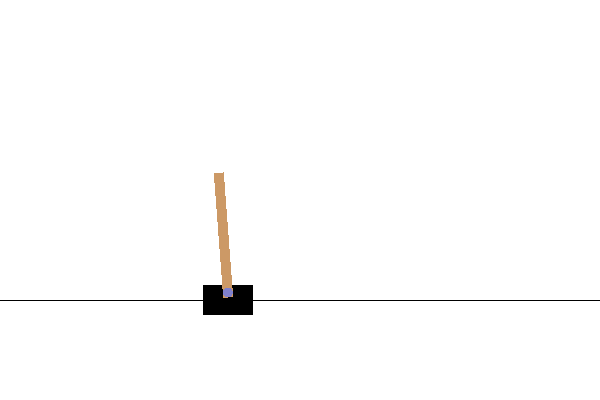
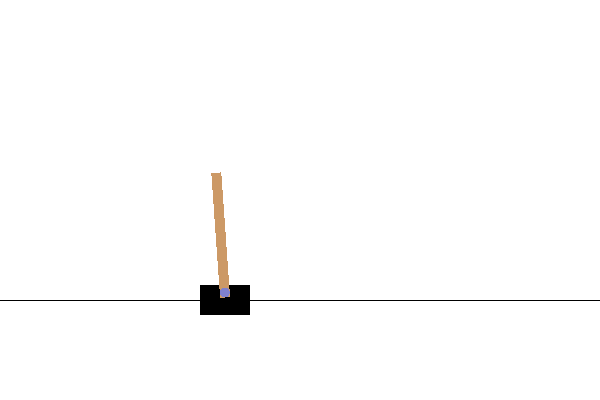
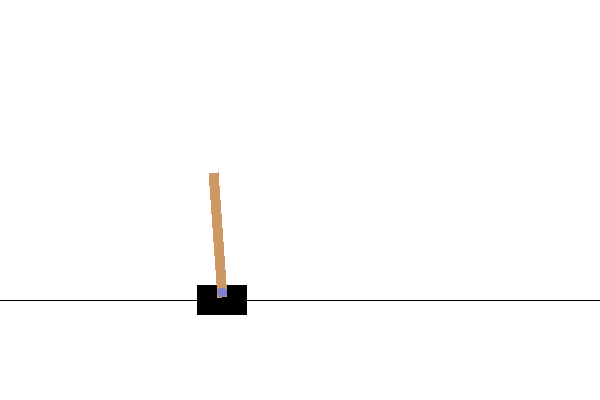
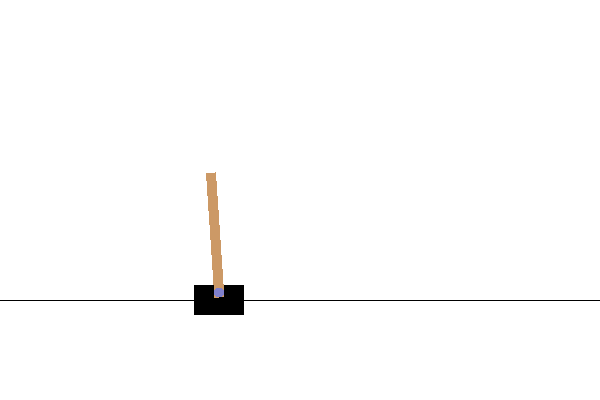
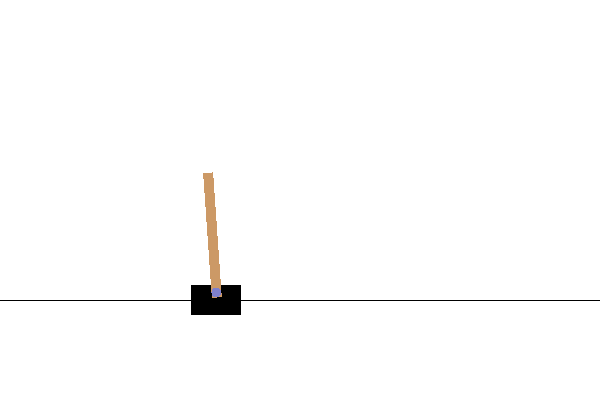
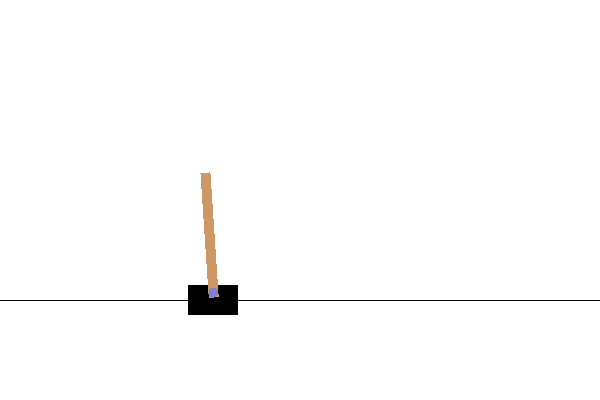
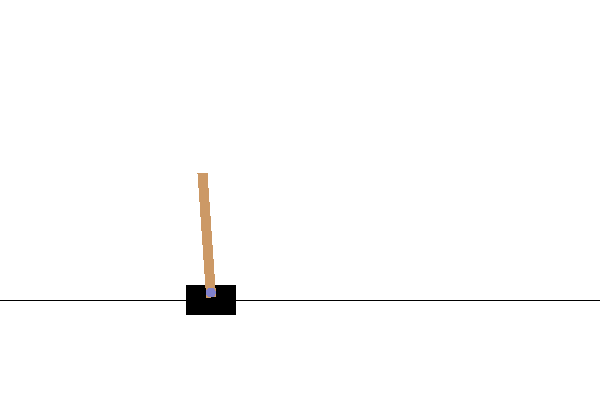
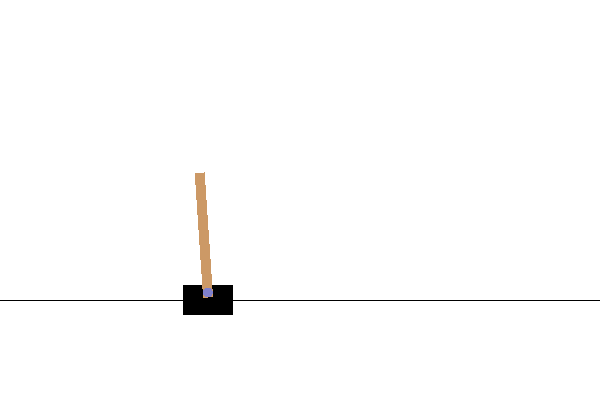
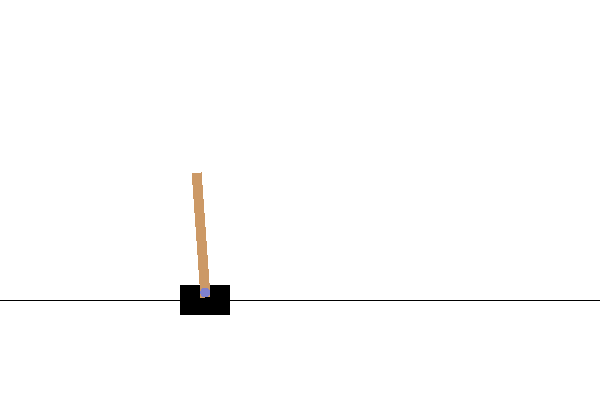
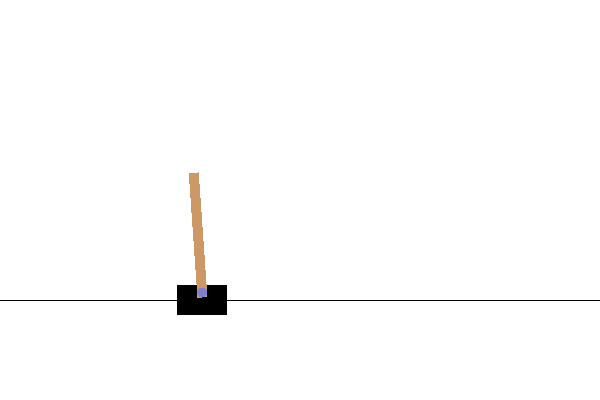
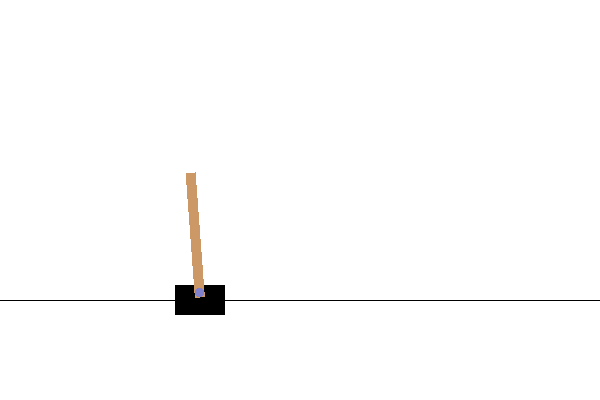
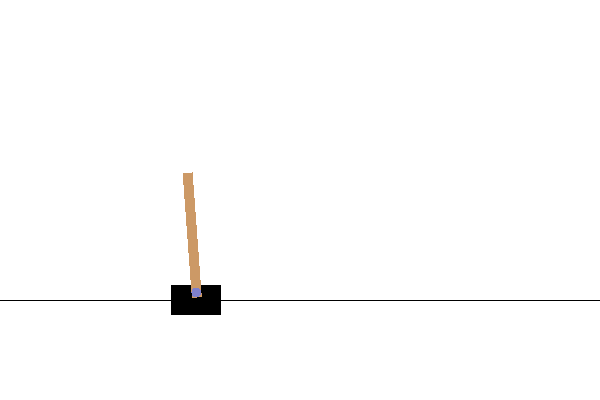
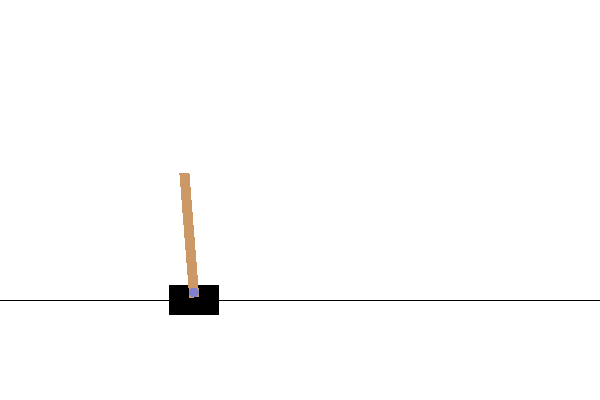
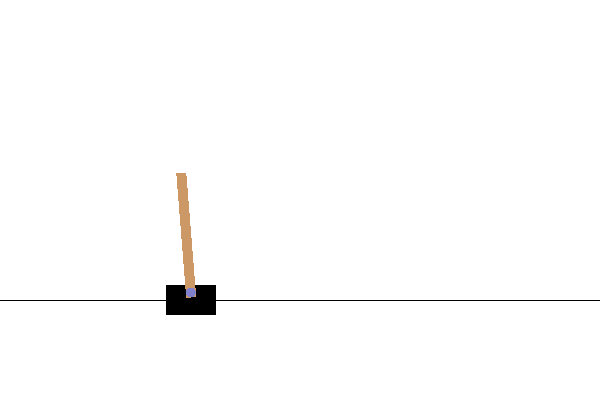
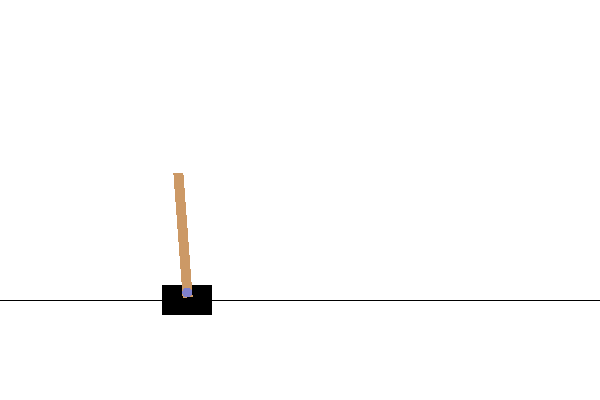
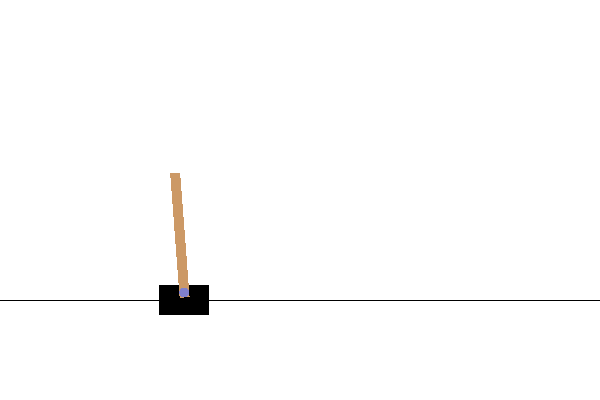
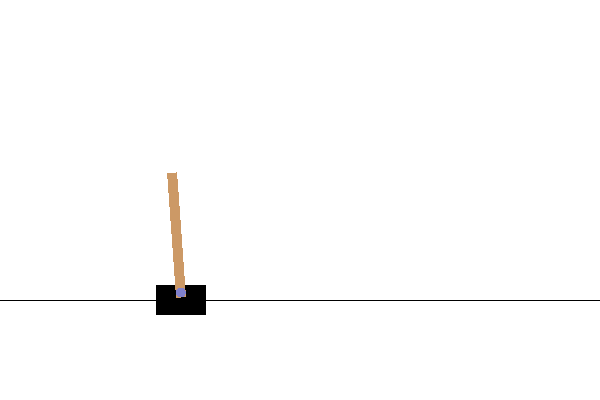
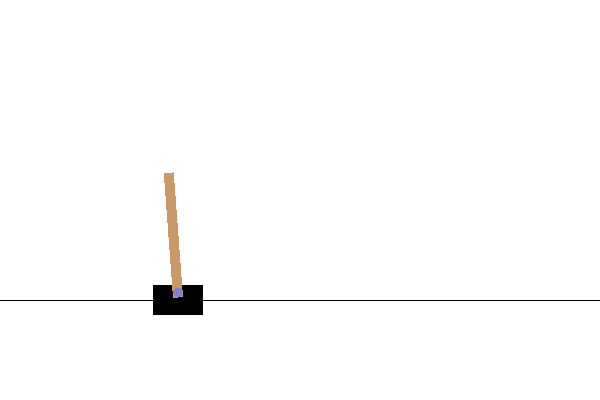
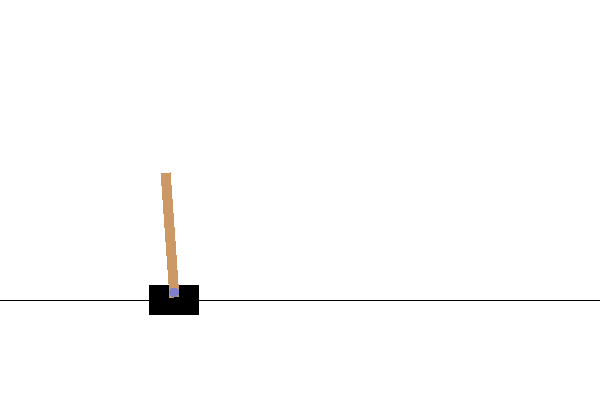
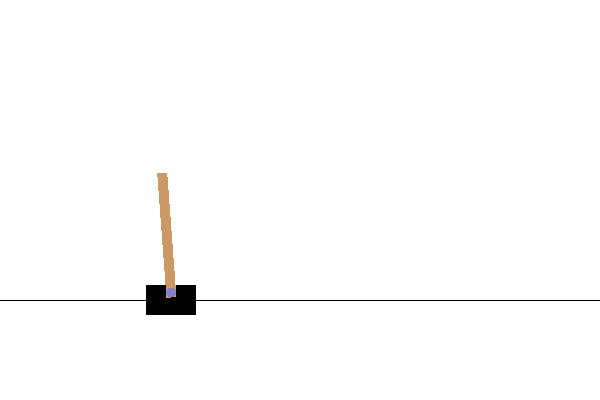
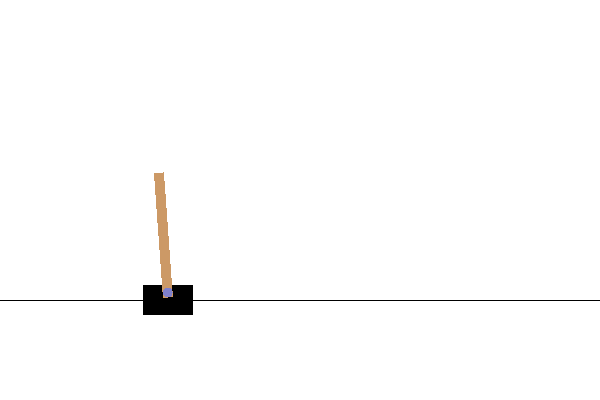
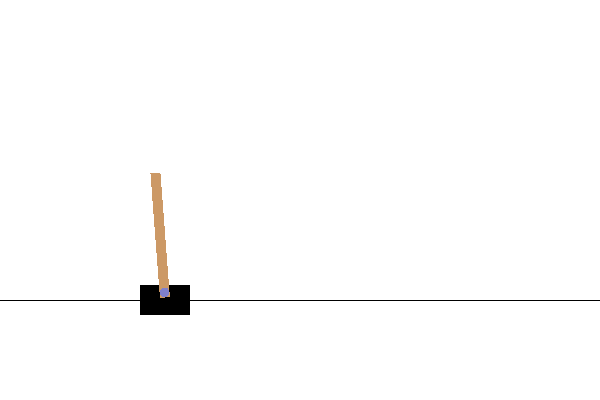
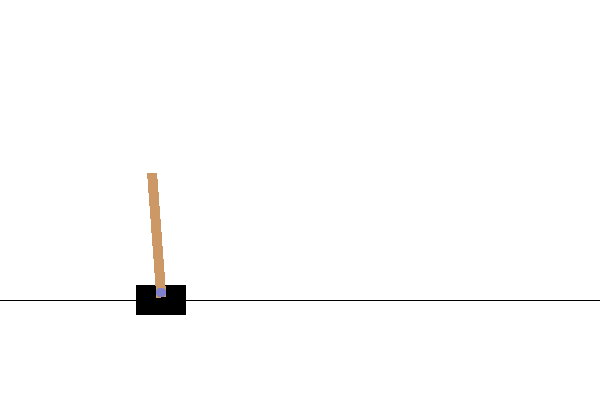
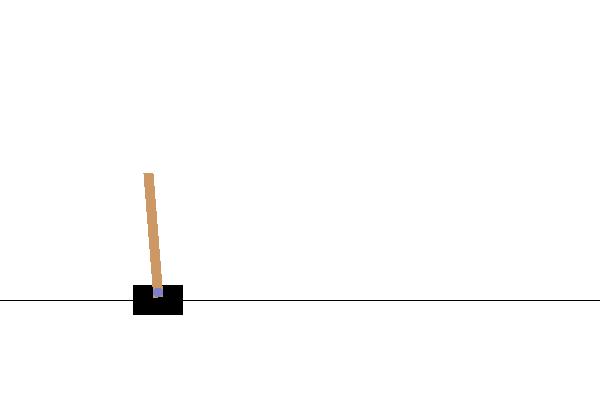
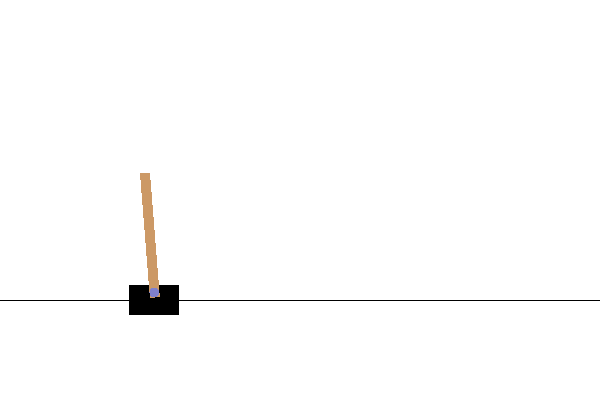
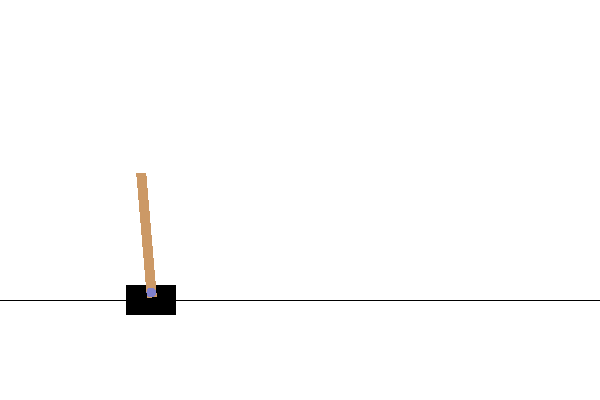
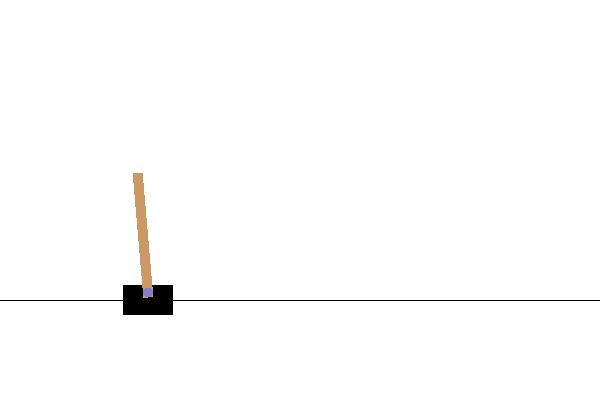
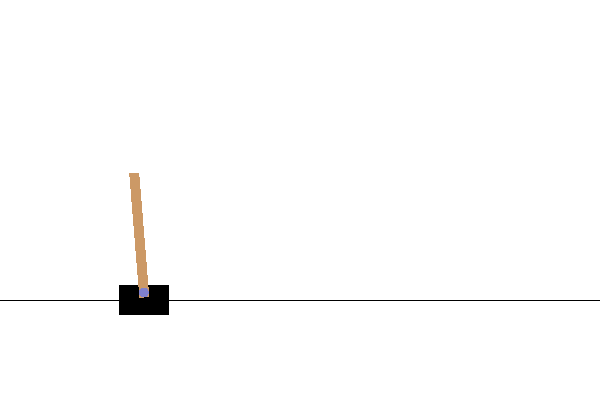
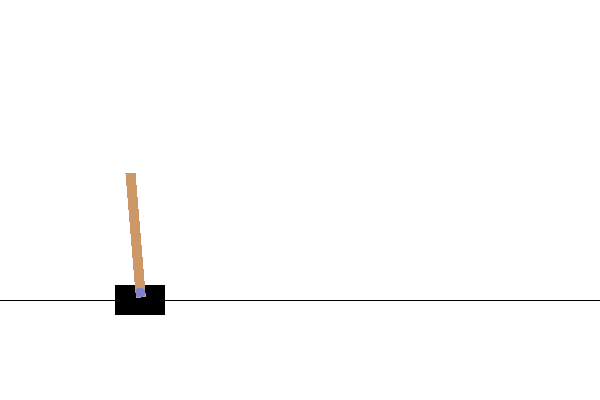
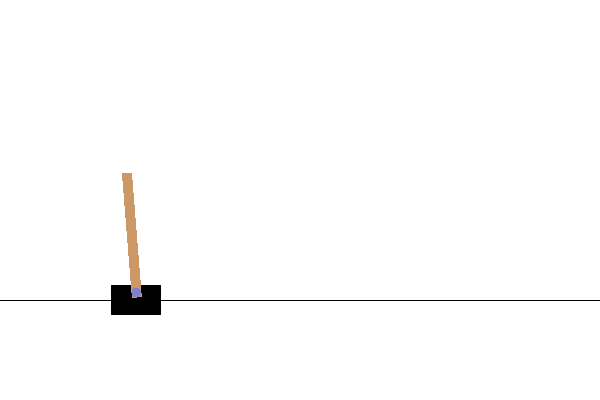
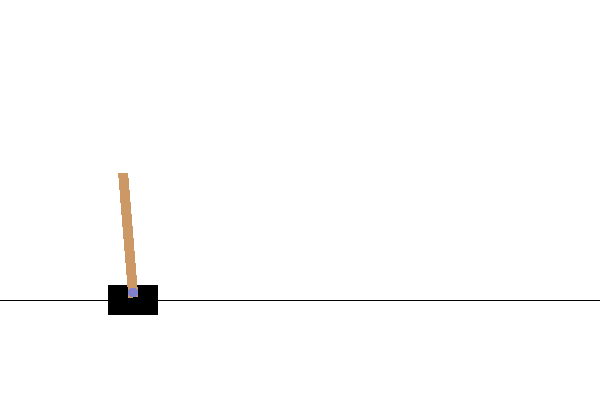
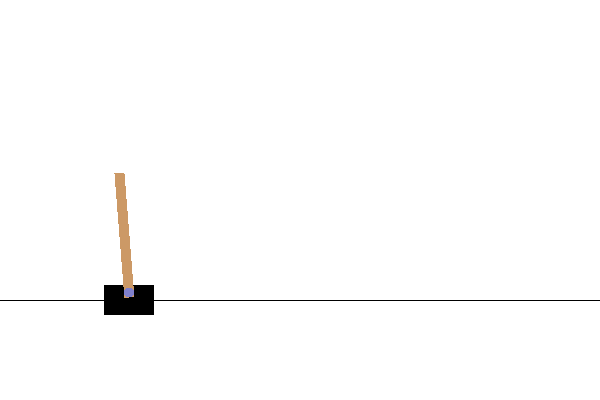
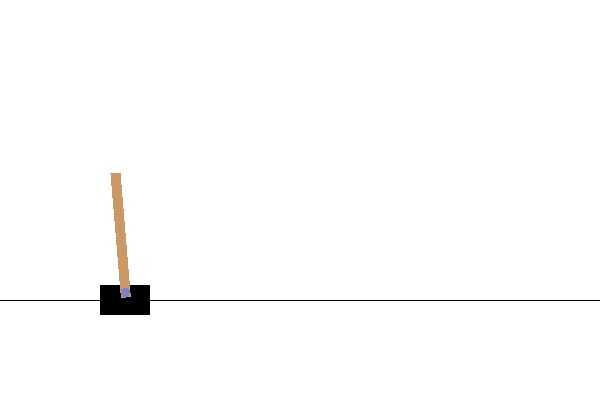
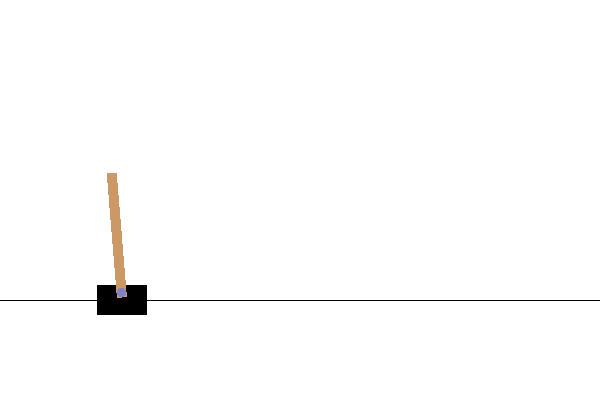
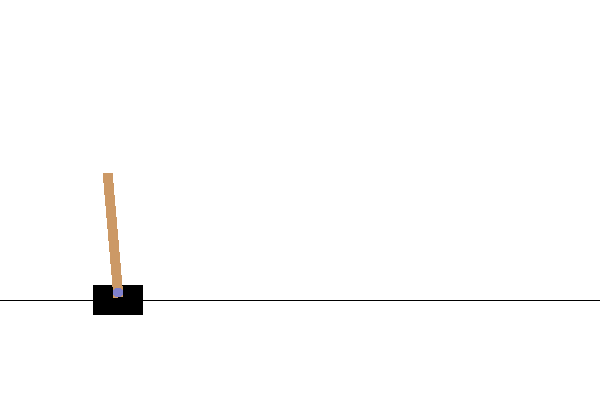
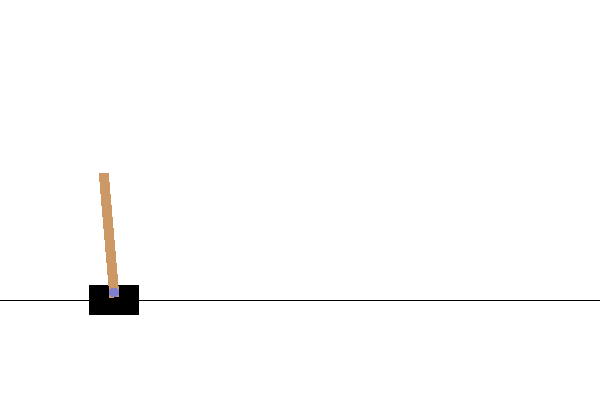
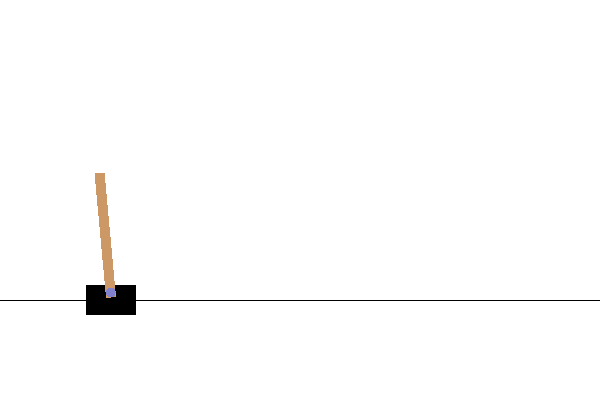
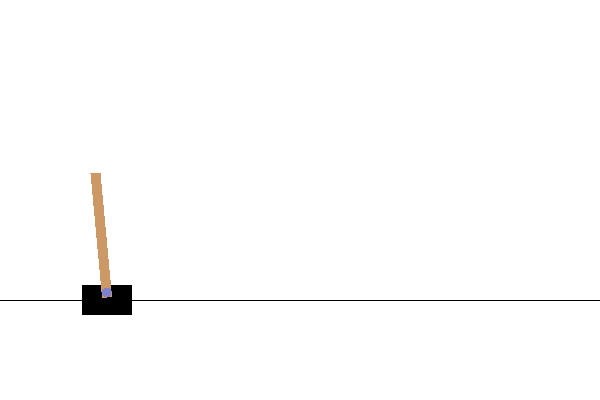
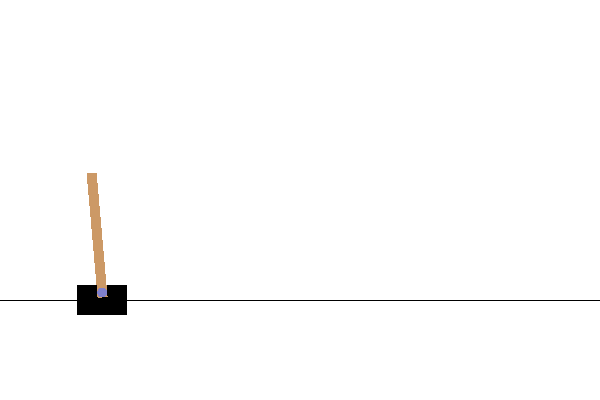
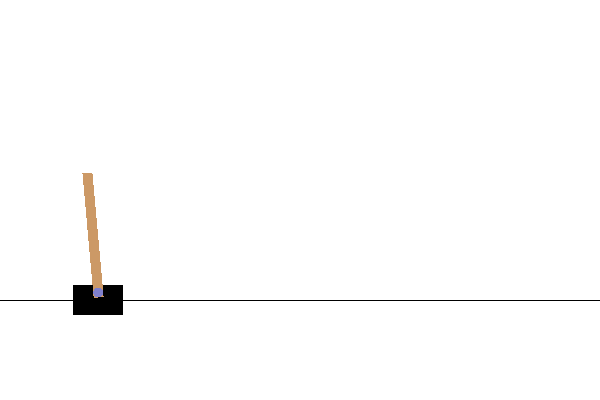
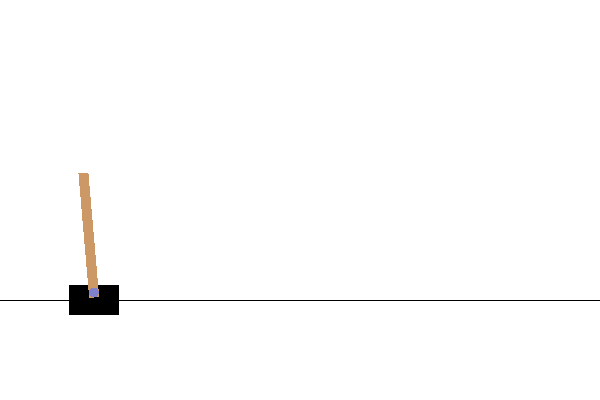
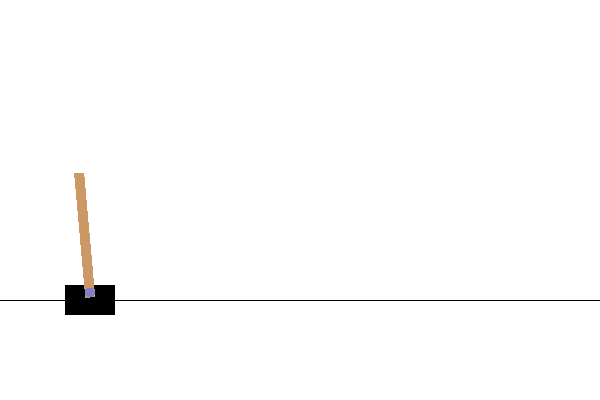
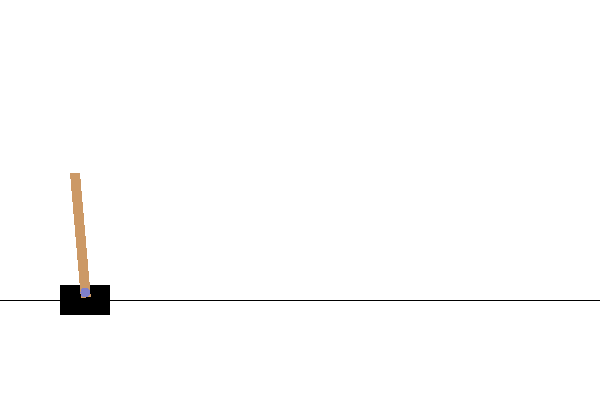
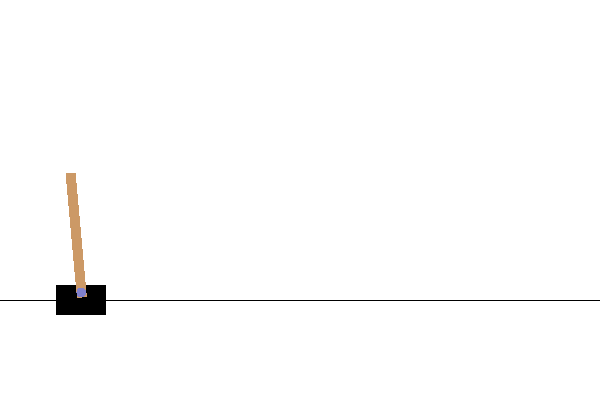
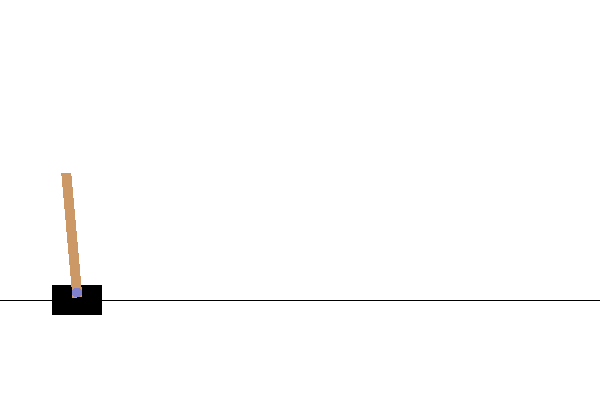
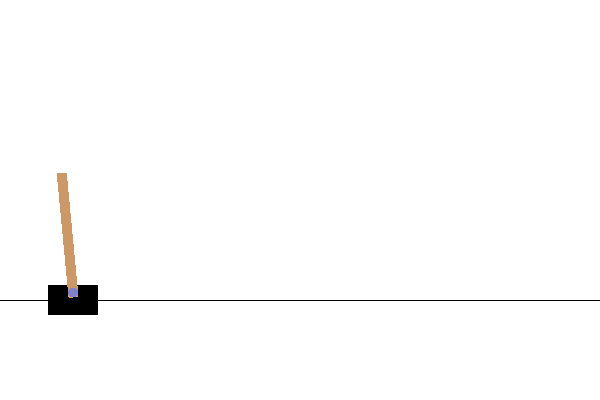
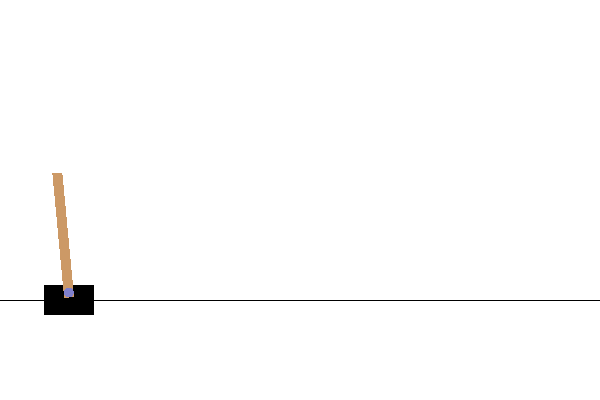
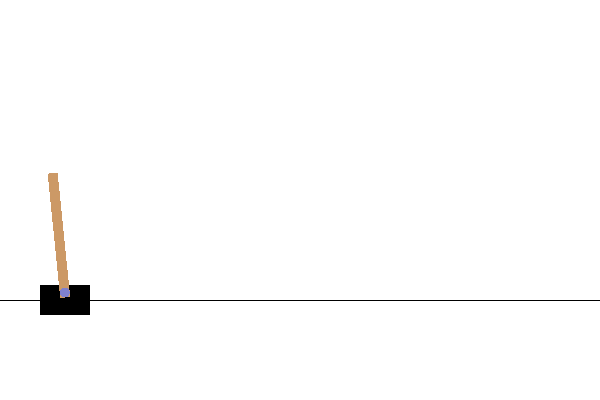
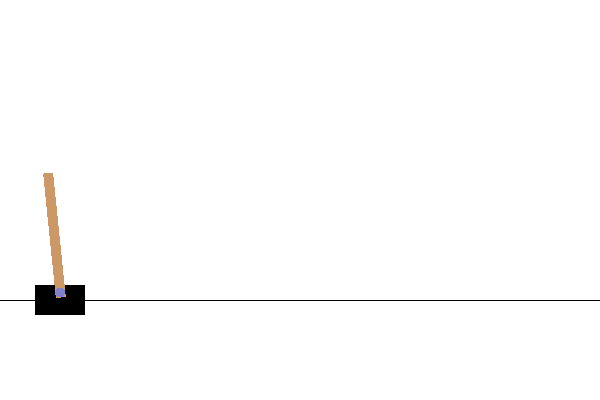
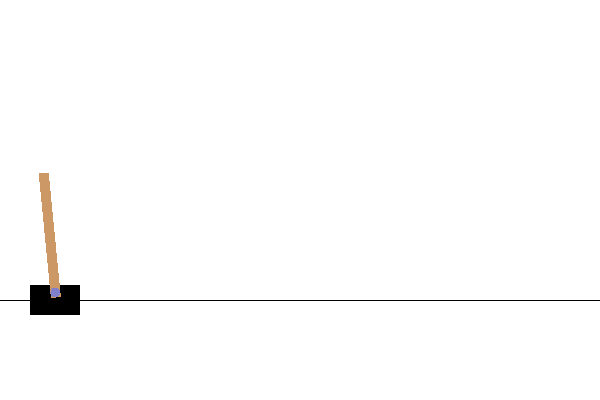
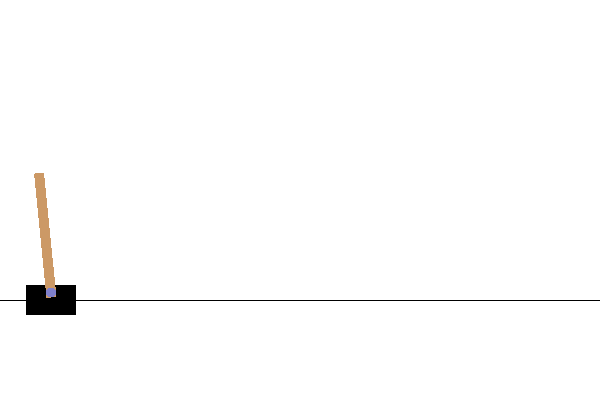
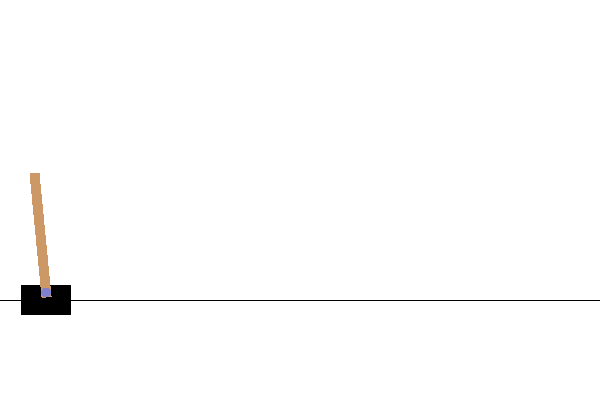
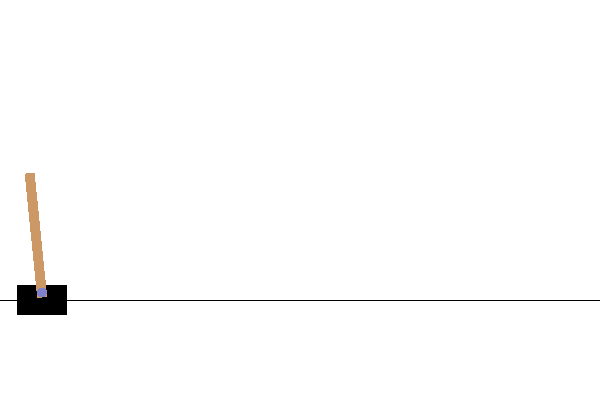
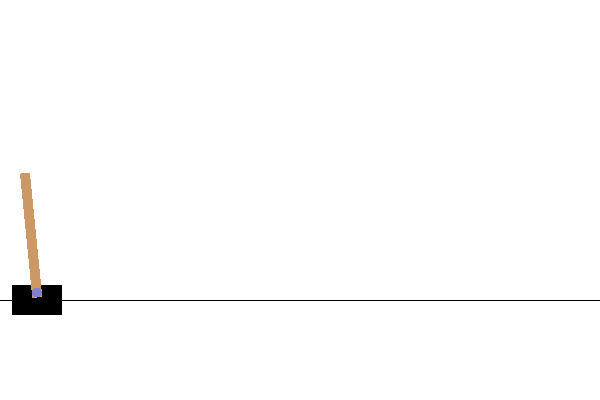
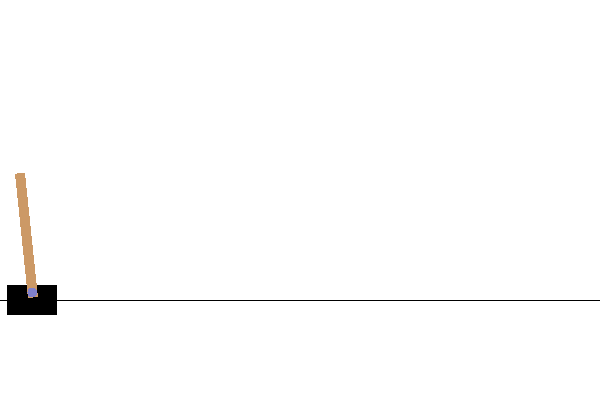
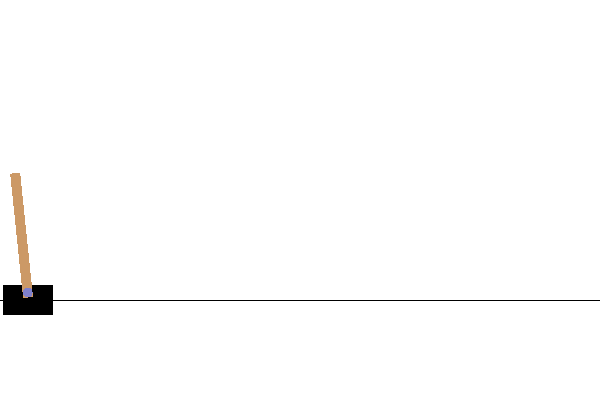
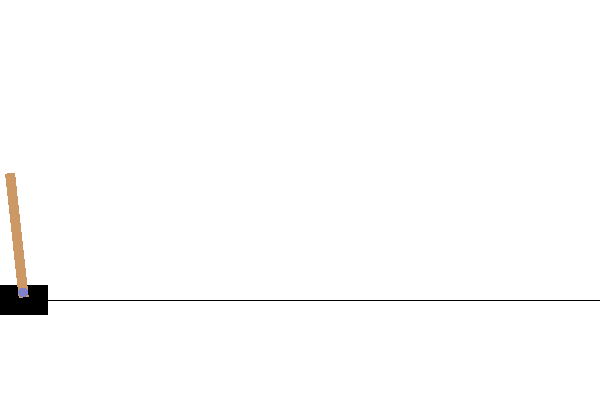
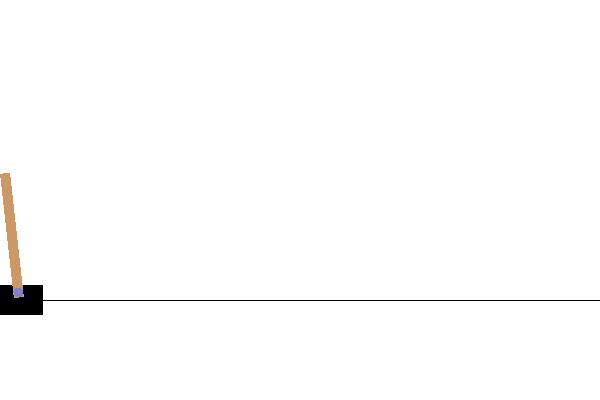
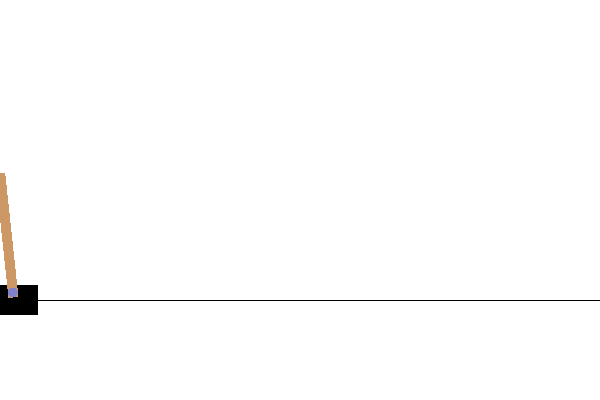
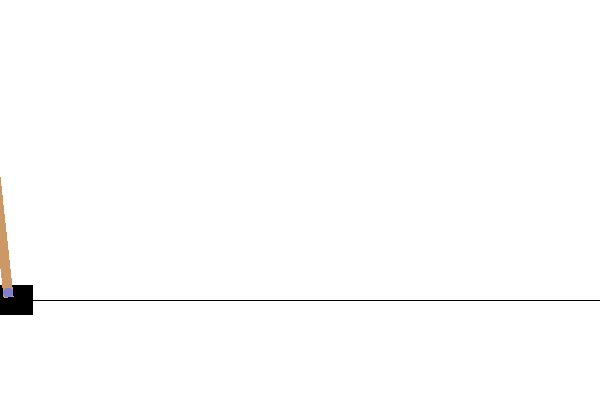
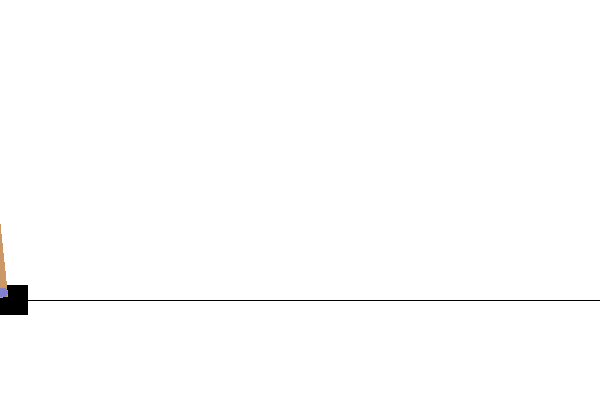
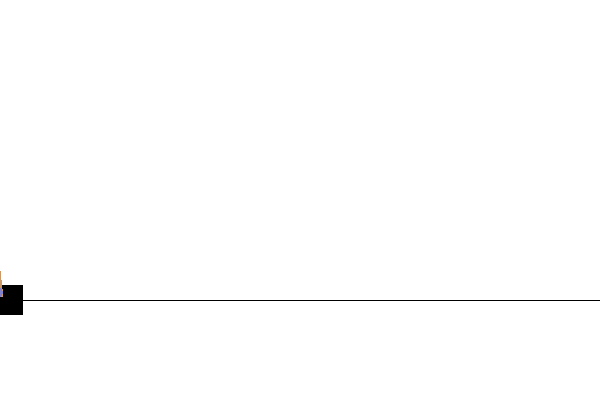

In [36]:
% matplotlib inline
plot_movie_js(images[6])

In [53]:
% matplotlib inline
plot_movie_mp4(images[6])